-----------------
Creating pictures: DCT visualisation, turn confusion matrix into confusion matrix heatmap, and the heatmap over the whole image
-----------------

First, Load the stuff you'll need

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

import numpy as np
import PIL

from tensorflow.python import pywrap_tensorflow
from tensorflow.python.platform import app
from tensorflow.python.platform import flags
from IPython.display import display, Image

from PIL import Image
import matplotlib.pyplot as plt


%matplotlib inline




//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:

def add_grid_lines(data, width, height, gridH, gridV):
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    myshape = picture.shape
    picture[:, 0:width:gridH, :] = 0
    picture[:, :, 0:height:gridV] = 0
    picture = picture.reshape((width*height*3), )
    return picture
    
def display_image_yuv(data, width, height):
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    myshape = picture.shape
    picture = picture[0]
    #plt.imshow(picture, cmap="hot")
    plt.imshow(picture, cmap="gray")
    plt.axis("off")
    plt.show()    

def thresholdAndRound(y):
    maxn = 255
    minn = 0
    y[y > maxn] = maxn
    y[y < minn] = minn
    y = np.around(y,0)
    return y

def convertToBytes(y):
    y = np.asarray(y, 'u1')
    return y


#Note that this function takes as input a planar RGB image
# It returns planar YUV4:4:4 (it's not common but it can be downsampled to 4:2:0)
def planarRGB_2_planarYUV(data, width, height):
    #print("in planarRGB_2_planarYUV")
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    r = np.array(picture[0])
    g = np.array(picture[1])
    b = np.array(picture[2])
    #print("orig R:" + str(r[0]))
    #print("orig G:" + str(g[0]))
    #print("orig B:" + str(b[0]))

    y = np.array(0.299*r + 0.587*g + 0.114*b)
    y = thresholdAndRound(y)
    u = ((b-y)*0.564) + delta
    v = ((r-y)*0.713) + delta
    
    #print("orig Y:" + str(y[0]))
    #print("orig U:" + str(u[0]))
    #print("orig V:" + str(v[0]))

    y = thresholdAndRound(y)
    u = thresholdAndRound(u)
    v = thresholdAndRound(v)
    y = convertToBytes(y)
    u = convertToBytes(u)
    v = convertToBytes(v)
    
    yuv = np.concatenate((y,u,v), axis = 0)
    yuv = yuv.reshape((width*height*3), )

    #print(y)
    #print(v)

    return yuv


# planar YUV 4:4:4 to rgb
def planarYUV_2_planarRGB(data, width, height):
    #print("in planarYUV_2_planarRGB")
    maxn = 255
    minn = 0
    delta = 128.0
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    y = picture[0]
    u = picture[1]
    v = picture[2]
    
    #print("recon Y:" + str(y[0]))
    #print("recon U:" + str(u[0]))
    #print("recon V:" + str(v[0]))

    
    r = y + 1.403 * (v-delta)
    g = y - (0.714 * (v-delta)) - (0.344 * (u-delta)) 
    b = y + 1.773 * (u-delta)

    #r = y + 1.13983 * v
    #g = y - (0.58060 * v) - (0.39465 * u) 
    #b = y + (2.03211 * u)


    r = thresholdAndRound(r)
    r = convertToBytes(r)
    g = thresholdAndRound(g)
    g = convertToBytes(g)
    b = thresholdAndRound(b)
    b = convertToBytes(b)
    #print("Reconstructed r:" + str(r[0]))
    #print("Reconstructed g:" + str(g[0]))
    #print("Reconstructed b:" + str(b[0]))

    rgb = np.concatenate((r,g,b), axis = 0)
    rgb = rgb.reshape((width*height*3), )
    return rgb

def saveToFile(data, filename):
    datayuv = np.asarray(data, 'u1')
    yuvByteArray = bytearray(datayuv)
    mylen = len(yuvByteArray)
    yuvFile = open(filename, "wb")
    yuvFile.write(yuvByteArray)
    yuvFile.close()

def appendToFile(data, filename):
    datayuv = np.asarray(data, 'u1')
    yuvByteArray = bytearray(datayuv)
    mylen = len(yuvByteArray)
    #print("Adding bytes to file: "+str(mylen))
    yuvFile = open(filename, "ab")
    yuvFile.write(yuvByteArray)
    yuvFile.close()
    
    
def savePic(saveName, rgbpic, height, width, border=False):
    test = np.asarray(rgbpic, 'u1')
    pictureA = test.reshape(3, height, width)
    pictureA = np.swapaxes(pictureA,0,1)
    pictureA = np.swapaxes(pictureA,1,2)
    pictureA = np.ndarray.flatten(pictureA)

    imageA = Image.frombytes('RGB', (height, width), pictureA)
    #imageB = imageA.resize(( (height*4), (width*4)), PIL.Image.LANCZOS)
    imageB = imageA.resize(( (height*4), (width*4)))

    if border:
        imageA = imageA.crop((-4, -4, height+4, width+4))
        imageB = imageB.crop((-4, -4, (height*4)+4, (width*4)+4))

    display(imageA)
    imageA.save(saveName, "PNG")  
    bigSaveName = "{}_big.png".format(saveName.replace('.png', ''))
    imageB.save(bigSaveName, "PNG")    


def display_image_rgb(data, width, height, interp_method='bilinear'):
    pic_planar = np.array(data)
    picture = pic_planar.reshape(3, width, height)
    myshape = picture.shape

    picture = np.swapaxes(picture,0,1)
    picture = np.swapaxes(picture,1,2)    

    plt.imshow(picture, interpolation=interp_method)
    plt.axis("off")
    plt.show()    




Trying to generate a pixel representation of the DCT coefficients (using inverse4x4 from the JM H.264 reference code).

In [53]:
#void inverse4x4(int **tblock, int **block, int pos_y, int pos_x)
# tblock is the transform block, block is the pixels
def inverse4x4(tblock):
    BLOCK_SIZE = 4
    block = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    tmp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    tmpIdx = 0
    
    tblock = np.asarray(tblock)
    tblock = tblock.astype(int)


    #int i, ii;  
    #int tmp[16];
    #int *pTmp = tmp, *pblock;
    #int p0,p1,p2,p3;
    #int t0,t1,t2,t3;
    p0 = 0
    p1 = 0
    p2 = 0
    p3 = 0
    t0 = 0
    t1 = 0
    t2 = 0
    t3 = 0

      # Horizontal
    #for (i = 0; i < BLOCK_SIZE; i++):
    for i in range(0, BLOCK_SIZE):
        t0 = tblock[(i*BLOCK_SIZE)]
        t1 = tblock[(i*BLOCK_SIZE)+1]
        t2 = tblock[(i*BLOCK_SIZE)+2]
        t3 = tblock[(i*BLOCK_SIZE)+3]

        p0 =  t0 + t2
        p1 =  t0 - t2
        p2 = (t1 >> 1) - t3
        p3 =  t1 + (t3 >> 1)
        
        tmp[tmpIdx] = p0 + p3
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] = p1 + p2
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] = p1 - p2
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] = p0 - p3
        tmpIdx = tmpIdx + 1

    #  Vertical 
    #for (i = 0; i < BLOCK_SIZE; i++):
    for i in range(0, BLOCK_SIZE):
        t0 = tmp[i]
        t1 = tmp[i+(BLOCK_SIZE)]
        t2 = tmp[i+(BLOCK_SIZE*2)]
        t3 = tmp[i+(BLOCK_SIZE*3)]

        p0 = t0 + t2
        p1 = t0 - t2
        p2 =(t1 >> 1) - t3
        p3 = t1 + (t3 >> 1)

        block[i]                = p0 + p3
        block[i+(BLOCK_SIZE)]   = p1 + p2
        block[i+(BLOCK_SIZE*2)] = p1 - p2
        block[i+(BLOCK_SIZE*3)] = p0 - p3
    
    
    block = np.asarray(block)
    #block = block.astype(int)

    #for i in range(0, BLOCK_SIZE*BLOCK_SIZE):
        #block[i] = ((block[i]+32)/64) + 128
    #block = np.floor(block)


    return block.astype(int)

def forward4x4(block):
    BLOCK_SIZE = 4
    tblock = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    tmp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    tmpIdx = 0
    p0 = 0
    p1 = 0
    p2 = 0
    p3 = 0
    t0 = 0
    t1 = 0
    t2 = 0
    t3 = 0
    
    block = np.asarray(block)
    block = block.astype(int)

    #Horizontal
    for i in range(0,BLOCK_SIZE):
        p0 = block[(i*BLOCK_SIZE)];
        p1 = block[(i*BLOCK_SIZE) + 1]
        p2 = block[(i*BLOCK_SIZE) + 2]
        p3 = block[(i*BLOCK_SIZE) + 3]

        t0 = p0 + p3;
        t1 = p1 + p2;
        t2 = p1 - p2;
        t3 = p0 - p3;

        tmp[tmpIdx] =  t0 + t1;
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] = (t3 << 1) + t2;
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] =  t0 - t1;
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] =  t3 - (t2 << 1);
        tmpIdx = tmpIdx + 1

    #Vertical
    for i in range(0,BLOCK_SIZE):

        p0 = tmp[i]
        p1 = tmp[i+(BLOCK_SIZE)]
        p2 = tmp[i+(BLOCK_SIZE*2)]
        p3 = tmp[i+(BLOCK_SIZE*3)]

        t0 = p0 + p3;
        t1 = p1 + p2;
        t2 = p1 - p2;
        t3 = p0 - p3;

        tblock[i] = t0 +  t1;
        tblock[i+(BLOCK_SIZE)] = t2 + (t3 << 1);
        tblock[i+(BLOCK_SIZE*2)] = t0 -  t1;
        tblock[i+(BLOCK_SIZE*3)] = t3 - (t2 << 1);
        
    #for i in range(0, BLOCK_SIZE*BLOCK_SIZE):
    #    tblock[i] = ((tblock[i]+32)/64) + 128
    #tblock = np.floor(tblock)
    tblock = np.asarray(tblock)
    for i in range(0, BLOCK_SIZE*BLOCK_SIZE):
        tblock[i] = tblock[i]/16

    return tblock.astype(int)

def inverse4x4_1(tblock):
    BLOCK_SIZE = 4
    block = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    tmp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    tmpIdx = 0
    
    tblock = np.asarray(tblock)
    tblock = tblock.astype(int)

    # Horizontal
    for i in range(0, BLOCK_SIZE):
        t0 = tblock[(i*BLOCK_SIZE)+0]
        t1 = tblock[(i*BLOCK_SIZE)+1]
        t2 = tblock[(i*BLOCK_SIZE)+2]
        t3 = tblock[(i*BLOCK_SIZE)+3]

        p0 =  t0 + t2
        p1 =  t0 - t2
        p2 = (t1 >> 1) - t3
        p3 =  t1 + (t3 >> 1)
        
        tmp[tmpIdx] = p0 + p3
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] = p1 + p2
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] = p1 - p2
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] = p0 - p3
        tmpIdx = tmpIdx + 1

    #  Vertical 
    for i in range(0, BLOCK_SIZE):
        t0 = tmp[i+(BLOCK_SIZE*0)]
        t1 = tmp[i+(BLOCK_SIZE*1)]
        t2 = tmp[i+(BLOCK_SIZE*2)]
        t3 = tmp[i+(BLOCK_SIZE*3)]

        p0 = t0 + t2
        p1 = t0 - t2
        p2 =(t1 >> 1) - t3
        p3 = t1 + (t3 >> 1)

        block[i]                = p0 + p3
        block[i+(BLOCK_SIZE)]   = p1 + p2
        block[i+(BLOCK_SIZE*2)] = p1 - p2
        block[i+(BLOCK_SIZE*3)] = p0 - p3

    block = np.asarray(block)

    return block.astype(int)

def forward4x4_1(block):
    BLOCK_SIZE = 4
    tblock = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    tmp = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    tmpIdx = 0
    
    block = np.asarray(block)

    #Horizontal
    for i in range(0,BLOCK_SIZE):
        p0 = block[(i*BLOCK_SIZE) + 0]
        p1 = block[(i*BLOCK_SIZE) + 1]
        p2 = block[(i*BLOCK_SIZE) + 2]
        p3 = block[(i*BLOCK_SIZE) + 3]


        t0 = p0 + p3;
        t1 = p1 + p2;
        t2 = p1 - p2;
        t3 = p0 - p3;

        tmp[tmpIdx] =  t0 + t1
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] = (t3 << 1) + t2
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] =  t0 - t1
        tmpIdx = tmpIdx + 1
        tmp[tmpIdx] =  t3 - (t2 << 1) 
        tmpIdx = tmpIdx + 1
    tmp = np.asarray(tmp)

    #Vertical
    for i in range(0,BLOCK_SIZE):

        p0 = tmp[i+(BLOCK_SIZE*0)]
        p1 = tmp[i+(BLOCK_SIZE*1)]
        p2 = tmp[i+(BLOCK_SIZE*2)]
        p3 = tmp[i+(BLOCK_SIZE*3)]

        t0 = p0 + p3;
        t1 = p1 + p2;
        t2 = p1 - p2;
        t3 = p0 - p3;

        tblock[i+(BLOCK_SIZE*0)] = t0 +  t1;
        tblock[i+(BLOCK_SIZE*1)] = t2 + (t3 << 1);
        tblock[i+(BLOCK_SIZE*2)] = t0 -  t1;
        tblock[i+(BLOCK_SIZE*3)] = t3 - (t2 << 1);
        
    tblock = np.asarray(tblock)
    return tblock





def displayArray(a, h, w):
    #add the channels
    uv = np.zeros(w*h)
    uv.fill(128)
    a = np.append(a, uv)
    a = np.append(a, uv)

    
    a = a.flatten()
    display_image_yuv(a, w, h)
    return a

    

aNumber = 8192
allData = []
myInput = [45, 76, 23, 54, 99, 123, 112, 71, 55, 1, 64, 103, 1, 23, 7, 44]
#myInput = [16, 16, 16, 16, 0,0,0,0,0,0,0,0,0,0,0,0]
#myInput = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,]
myInput = [5,11,8,10,9,8,4,12,1,10,11,4,19,6,15,7]

a = 0.5
b = 0.4**(0.5)

multiplierToCoeff = [(a*a),   (a*b/2), (a*a),   (a*b/2), 
              (a*b/2), (b*b/4), (a*b/2), (b*b/4),
              (a*a),(a*b/2),(a*a),(a*b/2),
              (a*b/2), (b*b/4), (a*b/2), (b*b/4)]
multiplierToCoeff = np.asarray(multiplierToCoeff)
print(multiplierToCoeff)

multiplierFromCoeff = [(a*a), (a*b), (a*a), (a*b),
                       (a*b), (b*b), (a*b), (b*b),
                       (a*a), (a*b), (a*a), (a*b),
                       (a*b), (b*b), (a*b), (b*b)]
multiplierFromCoeff = np.asarray(multiplierFromCoeff)
print(multiplierFromCoeff)

ato4 = a**4
bto4 = (b**4)/4
m = 0.05

comboMultiplier = [ato4, m, ato4, m,
                  m, bto4, m, bto4,
                  ato4, m, ato4, m,
                  m, bto4, m, bto4]





print("The input")
print(myInput)
mycoeffs = forward4x4_1(myInput)
print("After Forward")
print(mycoeffs)
mycoeffs1 = mycoeffs
mycoeffs = np.multiply(mycoeffs, multiplierToCoeff)
print("After multiply")
print(mycoeffs)

mycoeffs = np.multiply(mycoeffs, multiplierFromCoeff)
mycoeffs1 = np.multiply(mycoeffs1, comboMultiplier)
print("Scaling some more")

print(mycoeffs1)
mycoeffs = mycoeffs.astype(int)
print(mycoeffs)
mycoeffs = np.asarray([9,  0,  0,  0,  1,  2,   0,  -4,   1,  1, 1,    2,  -1,  -1,  -3,  -1])
#[ 8.75  -0.05  -0.375  0.35  -0.95  -1.56   0.35  -3.68   1.375  0.85 0.5    1.55  -1.35  -1.28  -2.95  -0.84 ]
mycoeffs = np.asarray([ 8,  0,  0,  0,  1, -1,  0, -3,  1,  1,  0,  1, -1, -1, -3,  0])

moreP = inverse4x4_1(mycoeffs)
print("After Inverse")
print(moreP)
print(myInput)








[0.25       0.15811388 0.25       0.15811388 0.15811388 0.1
 0.15811388 0.1        0.25       0.15811388 0.25       0.15811388
 0.15811388 0.1        0.15811388 0.1       ]
[0.25       0.31622777 0.25       0.31622777 0.31622777 0.4
 0.31622777 0.4        0.25       0.31622777 0.25       0.31622777
 0.31622777 0.4        0.31622777 0.4       ]
The input
[5, 11, 8, 10, 9, 8, 4, 12, 1, 10, 11, 4, 19, 6, 15, 7]
After Forward
[140  -1  -6   7 -19 -39   7 -92  22  17   8  31 -27 -32 -59 -21]
After multiply
[35.         -0.15811388 -1.5         1.10679718 -3.00416378 -3.9
  1.10679718 -9.2         5.5         2.68793601  2.          4.90153037
 -4.26907484 -3.2        -9.3287191  -2.1       ]
Scaling some more
[ 8.75  -0.05  -0.375  0.35  -0.95  -1.56   0.35  -3.68   1.375  0.85
  0.5    1.55  -1.35  -1.28  -2.95  -0.84 ]
[ 8  0  0  0  0 -1  0 -3  1  0  0  1 -1 -1 -2  0]
After Inverse
[ 5 11 10 10 10  8  2 13  2  8 10  3 15  5 10  6]
[5, 11, 8, 10, 9, 8, 4, 12, 1, 10, 11, 4, 19, 6, 15, 7]


Coeffnumber 0
[8192 8192 8192 8192 8192 8192 8192 8192 8192 8192 8192 8192 8192 8192
 8192 8192]


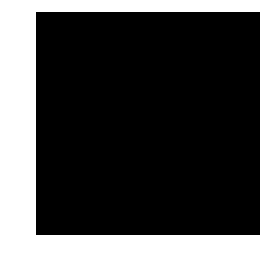

Size of all the kernels: 816
Coeffnumber 1
[ 8192  4096 -4096 -8192  8192  4096 -4096 -8192  8192  4096 -4096 -8192
  8192  4096 -4096 -8192]


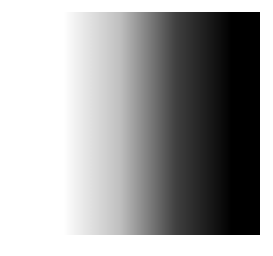

Size of all the kernels: 864
Coeffnumber 2
[ 8192 -8192 -8192  8192  8192 -8192 -8192  8192  8192 -8192 -8192  8192
  8192 -8192 -8192  8192]


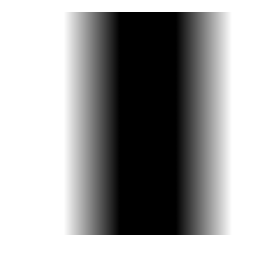

Size of all the kernels: 912
Coeffnumber 3
[ 4096 -8192  8192 -4096  4096 -8192  8192 -4096  4096 -8192  8192 -4096
  4096 -8192  8192 -4096]


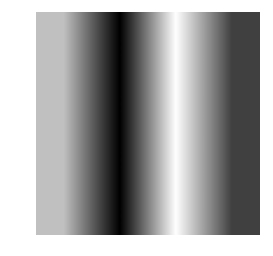

Size of all the kernels: 960
Coeffnumber 4
[ 8192  8192  8192  8192  4096  4096  4096  4096 -4096 -4096 -4096 -4096
 -8192 -8192 -8192 -8192]


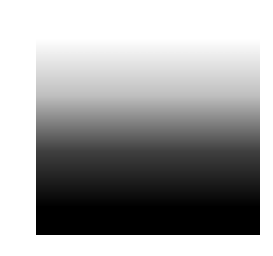

Size of all the kernels: 1008
Coeffnumber 5
[ 8192  4096 -4096 -8192  4096  2048 -2048 -4096 -4096 -2048  2048  4096
 -8192 -4096  4096  8192]


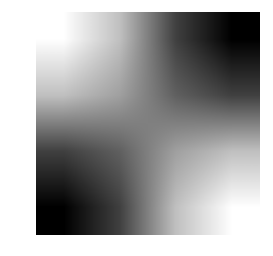

Size of all the kernels: 1056
Coeffnumber 6
[ 8192 -8192 -8192  8192  4096 -4096 -4096  4096 -4096  4096  4096 -4096
 -8192  8192  8192 -8192]


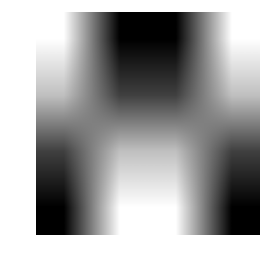

Size of all the kernels: 1104
Coeffnumber 7
[ 4096 -8192  8192 -4096  2048 -4096  4096 -2048 -2048  4096 -4096  2048
 -4096  8192 -8192  4096]


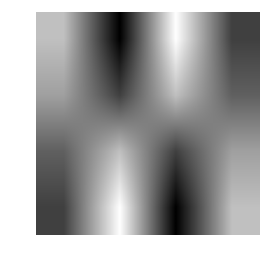

Size of all the kernels: 1152
Coeffnumber 8
[ 8192  8192  8192  8192 -8192 -8192 -8192 -8192 -8192 -8192 -8192 -8192
  8192  8192  8192  8192]


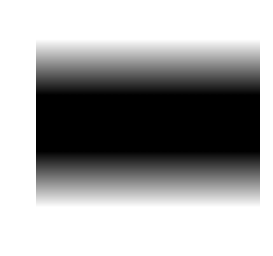

Size of all the kernels: 1200
Coeffnumber 9
[ 8192  4096 -4096 -8192 -8192 -4096  4096  8192 -8192 -4096  4096  8192
  8192  4096 -4096 -8192]


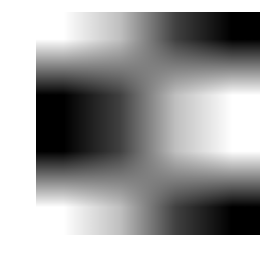

Size of all the kernels: 1248
Coeffnumber 10
[ 8192 -8192 -8192  8192 -8192  8192  8192 -8192 -8192  8192  8192 -8192
  8192 -8192 -8192  8192]


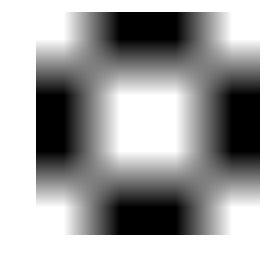

Size of all the kernels: 1296
Coeffnumber 11
[ 4096 -8192  8192 -4096 -4096  8192 -8192  4096 -4096  8192 -8192  4096
  4096 -8192  8192 -4096]


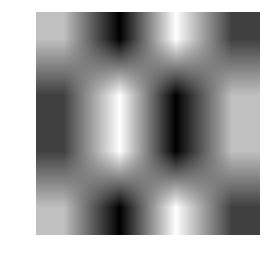

Size of all the kernels: 1344
Coeffnumber 12
[ 4096  4096  4096  4096 -8192 -8192 -8192 -8192  8192  8192  8192  8192
 -4096 -4096 -4096 -4096]


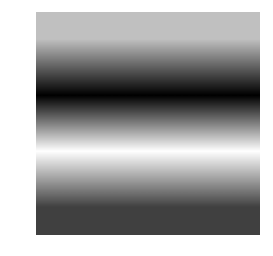

Size of all the kernels: 1392
Coeffnumber 13
[ 4096  2048 -2048 -4096 -8192 -4096  4096  8192  8192  4096 -4096 -8192
 -4096 -2048  2048  4096]


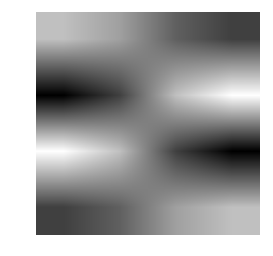

Size of all the kernels: 1440
Coeffnumber 14
[ 4096 -4096 -4096  4096 -8192  8192  8192 -8192  8192 -8192 -8192  8192
 -4096  4096  4096 -4096]


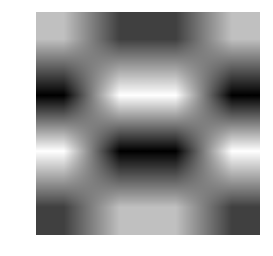

Size of all the kernels: 1488
Coeffnumber 15
[ 2048 -4096  4096 -2048 -4096  8192 -8192  4096  4096 -8192  8192 -4096
 -2048  4096 -4096  2048]


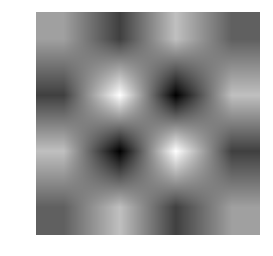

Size of all the kernels: 1536
[8192. 8192. 8192. ...  128.  128.  128.]


ValueError: cannot reshape array of size 1536 into shape (16,3,4,4)

In [6]:
for i in range(0, 16):
    
    coeff = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    coeff[i] = aNumber
    pixels = inverse4x4(coeff)
    
    #mycoeffs = forward4x4([128, 128, 128, 128,128, 128,128, 128,128, 128,128, 128,128, 128,128, 128])
    #mycoeffs = forward4x4([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    #mycoeffs = [128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

    print("Coeffnumber {}".format(i))
    print(pixels)
    
    
    a = displayArray(pixels, 4, 4)
    allData = np.append(allData, a)
    print("Size of all the kernels: {}".format(allData.size))

allData = np.array(allData)
print(allData)
#allData = allData.reshape(3,4,4,16)
allData = allData.reshape(16,3,4,4)
allData = np.swapaxes(allData,1,0)
allData = np.swapaxes(allData,2,1)
allData = np.swapaxes(allData,3,2)



(3, 4, 4, 16)
(3, 4, 4, 16)
768


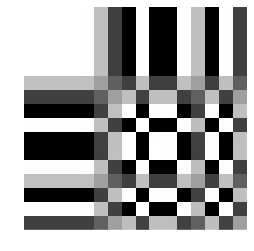

In [5]:
#reshape
def displayKernelMap(c1w, kernelheight, kernelwidth, heightInKernels, widthInKernels):
    print(c1w.shape)
    tryAgain = []
    idx = 0
    for c in range (0,3):
        for ky in range(0,heightInKernels):
            for y in range(0,kernelheight):
                for kx in range(0,widthInKernels):
                    yuv_data = c1w[c,y,:,(ky*widthInKernels)+kx].copy()
                    #yuv_data = yuv_data.flatten()
                    #print("The {} data: {}".format(idx, yuv_data))
                    tryAgain.extend(yuv_data)
                    #tryAgain.append(255)
                    idx = idx + 1


    width = kernelwidth*widthInKernels
    height = kernelheight*heightInKernels


    yuv_data = tryAgain
    print(len(yuv_data))
    rgbpic = planarYUV_2_planarRGB(yuv_data, width, height)
    display_image_rgb(rgbpic, width, height, interp_method="none")





print(allData.shape)
displayKernelMap(allData, 4, 4, 4, 4)

(3, 4, 4, 16)
1200


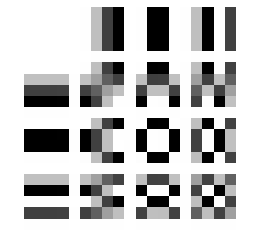

In [6]:
#reshape
def displayKernelMap_withSpaces(c1w, kernelheight, kernelwidth, heightInKernels, widthInKernels, savePicName):

    print(c1w.shape)
    tryAgain = []
    idx = 0
    for c in range (0,3):
        if c==0: 
            gridValue = 255
        else:
            gridValue = 128
        for ky in range(0,heightInKernels):
            for y in range(0,kernelheight):
                for kx in range(0,widthInKernels):
                    yuv_data = c1w[c,y,:,(ky*widthInKernels)+kx].copy()
                    #yuv_data = yuv_data.flatten()
                    yuv_data = np.append(yuv_data, gridValue)
                    #print("The {} data: {}".format(idx, yuv_data))
                    tryAgain.extend(yuv_data)
                    #tryAgain.append(255)
                    idx = idx + 1
                #Grid lines...
            for kx in range(0,widthInKernels):
                yuv_data = []
                for x in range(0, kernelwidth+1):
                    yuv_data = np.append(yuv_data, gridValue)
                #print("The {} data: {}".format(idx, yuv_data))
                tryAgain.extend(yuv_data)
                #tryAgain.append(255)
                #idx = idx + 1



    width = (kernelwidth+1)*widthInKernels
    height = (kernelheight+1)*heightInKernels


    yuv_data = tryAgain
    print(len(yuv_data))
    rgbpic = planarYUV_2_planarRGB(yuv_data, width, height)
    display_image_rgb(rgbpic, width, height, "none")


    savePic(savePicName, rgbpic, height, width, border=False)

displayKernelMap_withSpaces(allData, 4, 4, 4, 4, "4x4DCT.png")



-----------
Something else: Confusion matrix viewing
-----------

The example


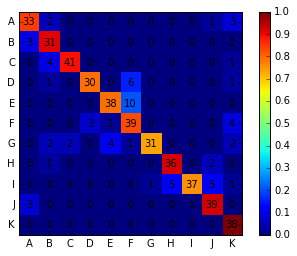

My nwa 10 averaged confusion matrix


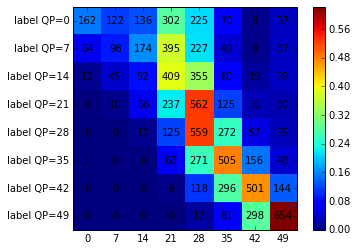

My reduced nwa 10 averaged confusion matrix


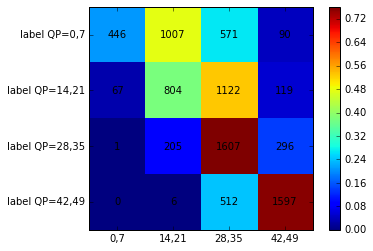

My nwa 10 averaged confusion matrix from a network actually trained on the reduced label set


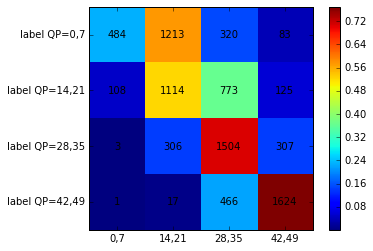

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



def generateConfusionMatrixPicture(conf_arr, pictureName, xlabels="", ylabels=""):
    norm_conf = []
    for i in conf_arr:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                    interpolation='nearest')

    width, height = conf_arr.shape

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

    cb = fig.colorbar(res)
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    if xlabels == "":
        xlabels = alphabet[:width]
    if ylabels == "":
        ylabels = alphabet[:height]
        
    plt.xticks(range(width), xlabels)
    plt.yticks(range(height), ylabels)
    plt.savefig(pictureName, format='png')
    plt.show()

conf_arr = np.array([[33,2,0,0,0,0,0,0,0,1,3], 
            [3,31,0,0,0,0,0,0,0,0,0], 
            [0,4,41,0,0,0,0,0,0,0,1], 
            [0,1,0,30,0,6,0,0,0,0,1], 
            [0,0,0,0,38,10,0,0,0,0,0], 
            [0,0,0,3,1,39,0,0,0,0,4], 
            [0,2,2,0,4,1,31,0,0,0,2],
            [0,1,0,0,0,0,0,36,0,2,0], 
            [0,0,0,0,0,0,1,5,37,5,1], 
            [3,0,0,0,0,0,0,0,0,39,0], 
            [0,0,0,0,0,0,0,0,0,0,38]])

print("The example")
generateConfusionMatrixPicture(conf_arr, "cm_example.png")

nwa10_AllVid_80_100k = np.array([[162,122,136,302,225,70,8,37],
                    [64,98,174,395,227,49,8,37],
                    [12,45,92,409,355,80,19,39],
                    [0,10,66,237,562,125,31,30],
                    [0,0,12,125,559,272,57,35],
                    [1,0,0,68,271,505,156,48],
                    [0,0,0,6,118,296,501,144],
                    [0,0,0,0,17,81,298,654]])

print("My nwa 10 averaged confusion matrix")
xlabels = ["0", "7", "14", "21", "28", "35", "42", "49"]
ylabels = ["label QP=0", "label QP=7", "label QP=14", "label QP=21", "label QP=28", "label QP=35", "label QP=42", "label QP=49"]
generateConfusionMatrixPicture(nwa10_AllVid_80_100k, "cm_nwa10_AllVid_80_100k.png", xlabels, ylabels)


nwa10_AllVid_80_100k_reduced = np.array([[446,1007,571,90],
[67,804,1122,119],
[1,205,1607,296],
[0,6,512,1597]])

print("My reduced nwa 10 averaged confusion matrix")
xlabels = ["0,7", "14,21", "28,35", "42,49"]
ylabels = ["label QP=0,7", "label QP=14,21", "label QP=28,35", "label QP=42,49"]
generateConfusionMatrixPicture(nwa10_AllVid_80_100k_reduced, "cm_nwa10_AllVid_80_100k_reduced.png", xlabels, ylabels)

print("My nwa 10 averaged confusion matrix from a network actually trained on the reduced label set")
nwa10_AllVid_composed_80_100k = np.array([[484,1213,320,83],
[108,1114,773,125],
[3,306,1504,307],
[1,17,466,1624]])
xlabels = ["0,7", "14,21", "28,35", "42,49"]
ylabels = ["label QP=0,7", "label QP=14,21", "label QP=28,35", "label QP=42,49"]
generateConfusionMatrixPicture(nwa10_AllVid_composed_80_100k, "cm_nwa10_AllVid_composed_80_100k.png", xlabels, ylabels)




My nwa 10 averaged confusion matrix (400k steps, so converged)


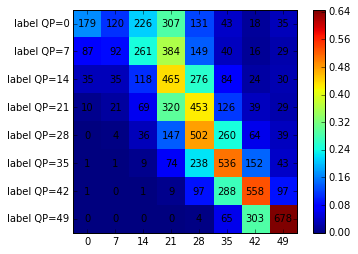

My reduced nwa 10 averaged confusion matrix (400k steps, so converged)


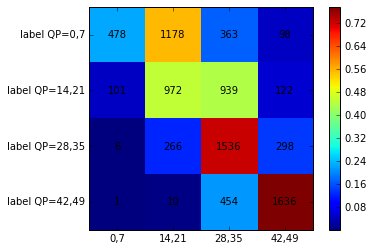

My nwa 10 averaged confusion matrix from a network actually trained on the reduced label set (400k steps, so converged)


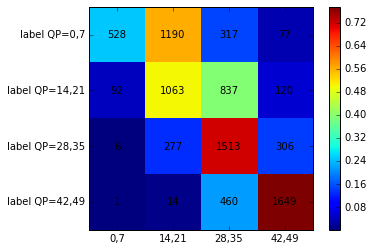

In [8]:
nwa10_AllVid_80_400k = np.array([179, 120, 226, 307, 131, 43, 18, 35,
87, 92, 261, 384, 149, 40, 16, 29,
35, 35, 118, 465, 276, 84, 24, 30,
10, 21, 69, 320, 453, 126, 39, 29,
0, 4, 36, 147, 502, 260, 64, 39,
1, 1, 9, 74, 238, 536, 152, 43,
1, 0, 1, 9, 97, 288, 558, 97,
0, 0, 0, 0, 4, 65, 303, 678])
nwa10_AllVid_80_400k = nwa10_AllVid_80_400k.reshape((8,8))

print("My nwa 10 averaged confusion matrix (400k steps, so converged)")
xlabels = ["0", "7", "14", "21", "28", "35", "42", "49"]
ylabels = ["label QP=0", "label QP=7", "label QP=14", "label QP=21", "label QP=28", "label QP=35", "label QP=42", "label QP=49"]
generateConfusionMatrixPicture(nwa10_AllVid_80_400k, "cm_nwa10_AllVid_80_400k.png", xlabels, ylabels)


nwa10_AllVid_80_400k_reduced = np.array([478, 1178, 363, 98,
101, 972, 939, 122,
6, 266, 1536, 298,
1, 10, 454, 1636])
nwa10_AllVid_80_400k_reduced = nwa10_AllVid_80_400k_reduced.reshape((4,4))

print("My reduced nwa 10 averaged confusion matrix (400k steps, so converged)")
xlabels = ["0,7", "14,21", "28,35", "42,49"]
ylabels = ["label QP=0,7", "label QP=14,21", "label QP=28,35", "label QP=42,49"]
generateConfusionMatrixPicture(nwa10_AllVid_80_400k_reduced, "cm_nwa10_AllVid_80_400k_reduced.png", xlabels, ylabels)

print("My nwa 10 averaged confusion matrix from a network actually trained on the reduced label set (400k steps, so converged)")
nwa10_AllVid_composed_80_400k = np.array([528, 1190, 317, 77,
92, 1063, 837, 120,
6, 277, 1513, 306,
1, 14, 460, 1649])
nwa10_AllVid_composed_80_400k = nwa10_AllVid_composed_80_400k.reshape((4,4))
xlabels = ["0,7", "14,21", "28,35", "42,49"]
ylabels = ["label QP=0,7", "label QP=14,21", "label QP=28,35", "label QP=42,49"]
generateConfusionMatrixPicture(nwa10_AllVid_composed_80_400k, "cm_nwa10_AllVid_composed_80_400k.png", xlabels, ylabels)



My nwa 10 averaged confusion matrix (400k steps, so converged)


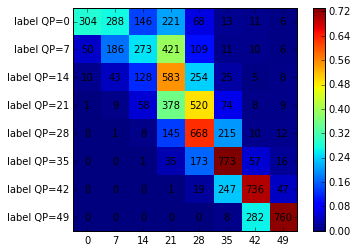

My reduced nwa 10 averaged confusion matrix (400k steps, so converged)


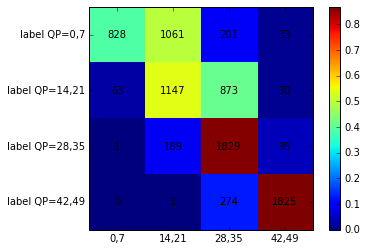

My nwa 10 averaged confusion matrix from a network actually trained on the reduced label set (400k steps, so converged)


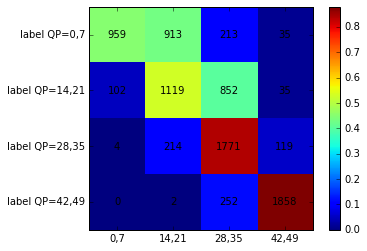

In [9]:
nwa10_AllIntra_80_400k = np.array([304, 288, 146, 221, 68, 13, 11, 6, 50, 
                                  186, 273, 421, 109, 11, 10, 6, 
                                  10, 43, 128, 583, 254, 25, 5, 8,
                                  1, 9, 58, 378, 520, 74, 8, 9,
                                  0, 1, 8, 145, 668, 215, 10, 12,
                                  0, 0, 1, 35, 173, 773, 57, 16,
                                  0, 0, 0, 1, 19, 247, 736, 47,
                                  0, 0, 0, 0, 0, 8, 282, 760])

nwa10_AllIntra_80_400k = nwa10_AllIntra_80_400k.reshape((8,8))

print("My nwa 10 averaged confusion matrix (400k steps, so converged)")
xlabels = ["0", "7", "14", "21", "28", "35", "42", "49"]
ylabels = ["label QP=0", "label QP=7", "label QP=14", "label QP=21", "label QP=28", "label QP=35", "label QP=42", "label QP=49"]
generateConfusionMatrixPicture(nwa10_AllIntra_80_400k, "cm_nwa10_AllIntra_80_400k.png", xlabels, ylabels)


nwa10_AllIntra_80_400k_reduced = np.array([828, 1061, 201, 33,
63, 1147, 873, 30,
1, 189, 1829, 95,
0, 1, 274, 1825])
nwa10_AllIntra_80_400k_reduced = nwa10_AllIntra_80_400k_reduced.reshape((4,4))

print("My reduced nwa 10 averaged confusion matrix (400k steps, so converged)")
xlabels = ["0,7", "14,21", "28,35", "42,49"]
ylabels = ["label QP=0,7", "label QP=14,21", "label QP=28,35", "label QP=42,49"]
generateConfusionMatrixPicture(nwa10_AllIntra_80_400k_reduced, "cm_nwa10_AllIntra_80_400k_reduced.png", xlabels, ylabels)

print("My nwa 10 averaged confusion matrix from a network actually trained on the reduced label set (400k steps, so converged)")
nwa10_AllIntra_composed_80_400k = np.array([959, 913, 213, 35,
102, 1119, 852, 35,
4, 214, 1771, 119,
0, 2, 252, 1858])
nwa10_AllIntra_composed_80_400k = nwa10_AllIntra_composed_80_400k.reshape((4,4))
xlabels = ["0,7", "14,21", "28,35", "42,49"]
ylabels = ["label QP=0,7", "label QP=14,21", "label QP=28,35", "label QP=42,49"]
generateConfusionMatrixPicture(nwa10_AllIntra_composed_80_400k, "cm_nwa10_AllIntra_composed_80_400k.png", xlabels, ylabels)




My UCID nwa 10 averaged confusion matrix on UCID test set (400k steps, so converged)


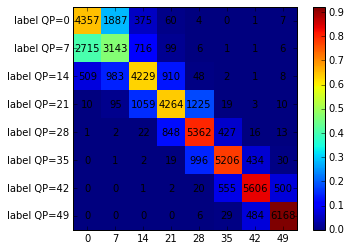

My UCID nwa 10 averaged confusion matrix on AllIntra_80 test set (400k steps, so converged)


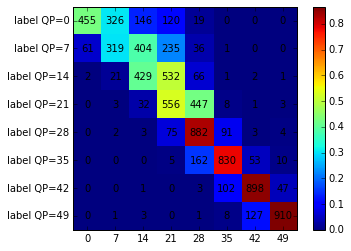

My reduced UCID nwa 10 averaged confusion matrix (400k steps, so converged)


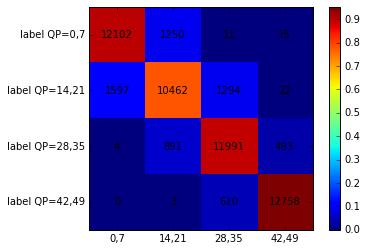

My UCID nwa 10 averaged confusion matrix from a network actually trained on the reduced label set (400k steps, so converged)


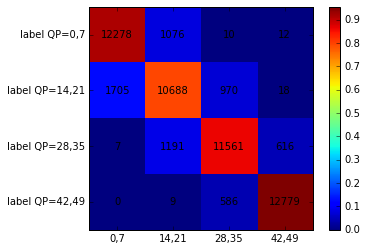

In [10]:
nwa10_UCID_80_400k = np.array([4357, 1887, 375, 60, 4, 0, 1, 7,
2715, 3143, 716, 99, 6, 1, 1, 6,
509, 983, 4229, 910, 48, 2, 1, 8,
10, 95, 1059, 4264, 1225, 19, 3, 10,
1, 2, 22, 848, 5362, 427, 16, 13,
0, 1, 2, 19, 996, 5206, 434, 30,
0, 0, 1, 2, 20, 555, 5606, 500,
0, 0, 0, 0, 6, 29, 484, 6168])

nwa10_UCID_80_400k = nwa10_UCID_80_400k.reshape((8,8))

print("My UCID nwa 10 averaged confusion matrix on UCID test set (400k steps, so converged)")
xlabels = ["0", "7", "14", "21", "28", "35", "42", "49"]
ylabels = ["label QP=0", "label QP=7", "label QP=14", "label QP=21", "label QP=28", "label QP=35", "label QP=42", "label QP=49"]
generateConfusionMatrixPicture(nwa10_UCID_80_400k, "cm_nwa10_UCID_80_400k.png", xlabels, ylabels)

nwa10_UCID_80_400k = np.array([455, 326, 146, 120, 19, 0, 0, 0,
61, 319, 404, 235, 36, 1, 0, 0,
2, 21, 429, 532, 66, 1, 2, 1,
0, 3, 32, 556, 447, 8, 1, 3,
0, 2, 3, 75, 882, 91, 3, 4,
0, 0, 0, 5, 162, 830, 53, 10,
0, 0, 1, 0, 3, 102, 898, 47,
0, 1, 3, 0, 1, 8, 127, 910])

nwa10_UCID_80_400k = nwa10_UCID_80_400k.reshape((8,8))

print("My UCID nwa 10 averaged confusion matrix on AllIntra_80 test set (400k steps, so converged)")
xlabels = ["0", "7", "14", "21", "28", "35", "42", "49"]
ylabels = ["label QP=0", "label QP=7", "label QP=14", "label QP=21", "label QP=28", "label QP=35", "label QP=42", "label QP=49"]
generateConfusionMatrixPicture(nwa10_UCID_80_400k, "cm_nwa10_UCID_80(AllIntraTest)_400k.png", xlabels, ylabels)


nwa10_UCID_80_400k_reduced = np.array([12102, 1250, 11, 15,
1597, 10462, 1294, 22,
4, 891, 11991, 493,
0, 3, 610, 12758])
nwa10_UCID_80_400k_reduced = nwa10_UCID_80_400k_reduced.reshape((4,4))

print("My reduced UCID nwa 10 averaged confusion matrix (400k steps, so converged)")
xlabels = ["0,7", "14,21", "28,35", "42,49"]
ylabels = ["label QP=0,7", "label QP=14,21", "label QP=28,35", "label QP=42,49"]
generateConfusionMatrixPicture(nwa10_UCID_80_400k_reduced, "cm_nwa10_UCID_80_400k_reduced.png", xlabels, ylabels)

print("My UCID nwa 10 averaged confusion matrix from a network actually trained on the reduced label set (400k steps, so converged)")
nwa10_UCID_composed_80_400k = np.array([12278, 1076, 10, 12,
1705, 10688, 970, 18,
7, 1191, 11561, 616,
0, 9, 586, 12779])
nwa10_UCID_composed_80_400k = nwa10_UCID_composed_80_400k.reshape((4,4))
xlabels = ["0,7", "14,21", "28,35", "42,49"]
ylabels = ["label QP=0,7", "label QP=14,21", "label QP=28,35", "label QP=42,49"]
generateConfusionMatrixPicture(nwa10_UCID_composed_80_400k, "cm_nwa10_UCID_composed_80_400k.png", xlabels, ylabels)




-----------
Something else: A heatmap over an image
-----------

(9830912,)
There are 512 images in the file
Shape of allTheData array: (512, 19201)
Shape of labels array: (512,)
The index of the image is 373, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


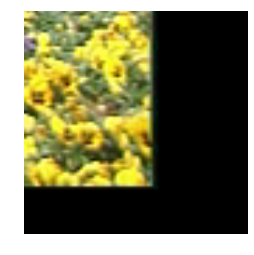

shape of rgb frame: (19200,)
The index of the image is 374, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


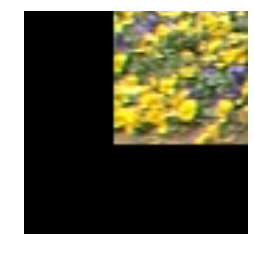

shape of rgb frame: (19200,)
The index of the image is 375, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


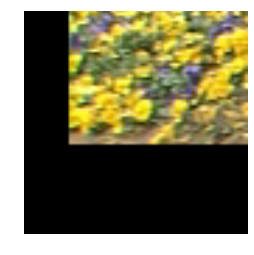

shape of rgb frame: (19200,)
The index of the image is 376, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


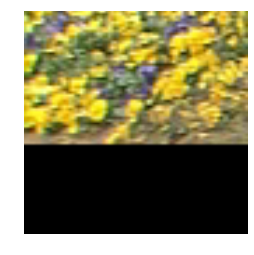

shape of rgb frame: (19200,)
The index of the image is 377, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


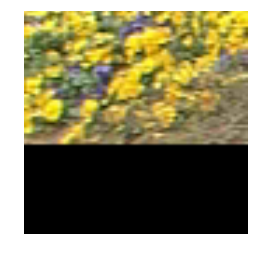

shape of rgb frame: (19200,)
The index of the image is 378, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


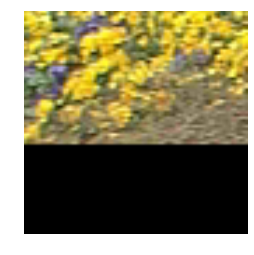

shape of rgb frame: (19200,)
The index of the image is 379, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


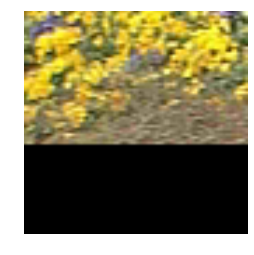

shape of rgb frame: (19200,)
The index of the image is 380, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


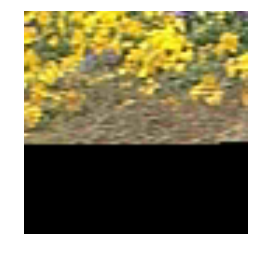

shape of rgb frame: (19200,)
The index of the image is 381, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


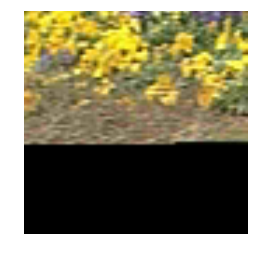

shape of rgb frame: (19200,)
The index of the image is 382, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


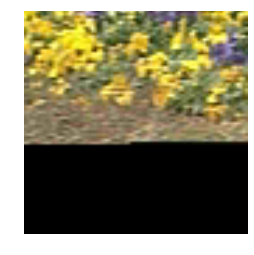

shape of rgb frame: (19200,)
The index of the image is 383, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


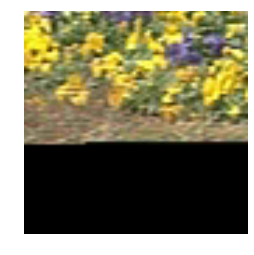

shape of rgb frame: (19200,)
The index of the image is 384, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


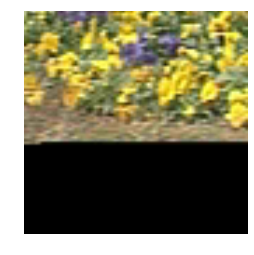

shape of rgb frame: (19200,)
The index of the image is 385, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


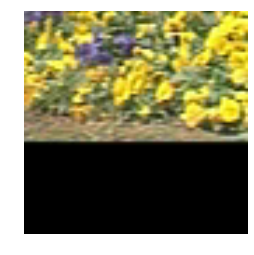

shape of rgb frame: (19200,)
The index of the image is 386, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


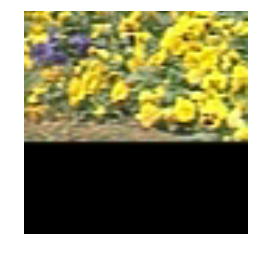

shape of rgb frame: (19200,)
The index of the image is 387, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


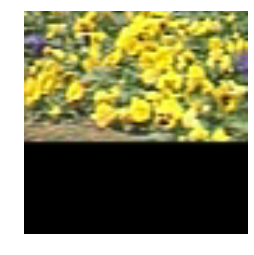

shape of rgb frame: (19200,)
The index of the image is 388, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


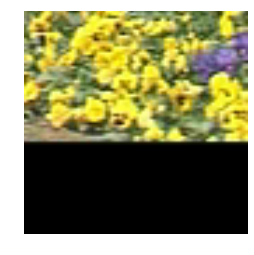

shape of rgb frame: (19200,)
The index of the image is 389, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


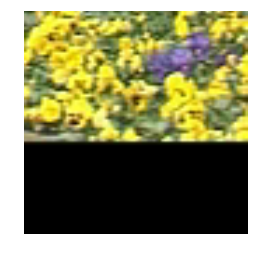

shape of rgb frame: (19200,)
The index of the image is 390, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


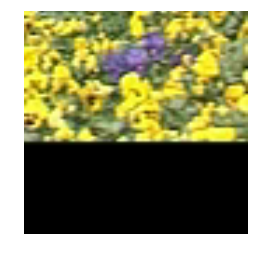

shape of rgb frame: (19200,)
The index of the image is 391, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


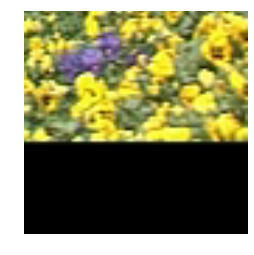

shape of rgb frame: (19200,)
The index of the image is 392, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


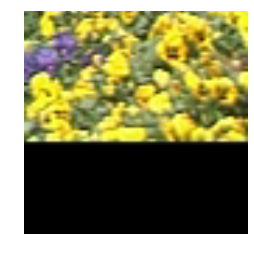

shape of rgb frame: (19200,)
The index of the image is 393, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


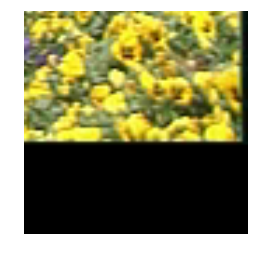

shape of rgb frame: (19200,)
The index of the image is 394, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


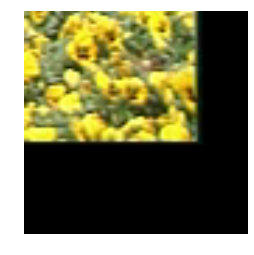

shape of rgb frame: (19200,)
The index of the image is 395, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


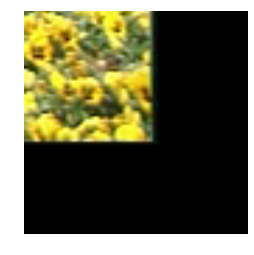

shape of rgb frame: (19200,)
The index of the image is 396, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


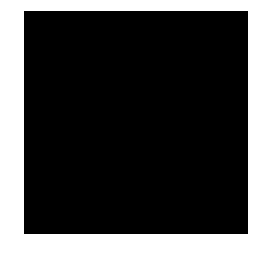

shape of rgb frame: (19200,)
The index of the image is 397, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


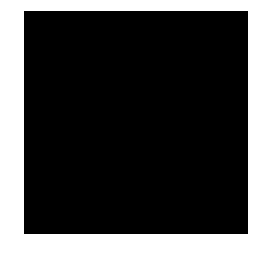

shape of rgb frame: (19200,)
The index of the image is 398, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


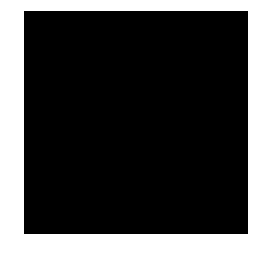

shape of rgb frame: (19200,)
The index of the image is 399, data shape (512, 19201)
/Users/pam/Documents/data/yuv/flower_1f_q0.bin
The label is 0
The quant is: 0


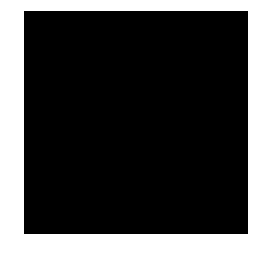

shape of rgb frame: (19200,)


In [11]:
import matplotlib.pyplot as plt
import random
from PIL import Image

data_folder = '/Users/pam/Documents/data/yuv/flower_1f_q0.bin'

folderFormat = 'yuv'

width = 80
height = 80
channels = 3

f = open(data_folder, "rb")
allTheData = np.fromfile(f, 'u1')
print(allTheData.shape)
recordSize = (width * height * channels) + 1
num_cases_per_batch = allTheData.shape[0] / recordSize
num_cases_per_batch = int(num_cases_per_batch)
print("There are {} images in the file".format(num_cases_per_batch))



allTheData = allTheData.reshape(num_cases_per_batch, recordSize)
data_labels = allTheData[:, 0].copy()
data_array = allTheData[:, 1:].copy()

print("Shape of allTheData array: {}".format(allTheData.shape))
print("Shape of labels array: {}".format(data_labels.shape))


index = random.randint(0,num_cases_per_batch)
index = 0
indexes = [0, 1, 2, 3, 43, 44, 45]
indexes = range(373,400)


for index in indexes:
    print('The index of the image is {}, data shape {}'.format(index, allTheData.shape))
    print(data_folder)


    # Try scaling it up a bit
    scaleUp = False
    if scaleUp == True:
        myframe = data_array[index]
        pixel_depth = 8
        myframe = myframe * pixel_depth
        myframe = doubleImage(myframe, height, width)
        rgbframe = planarYUV_2_planarRGB(myframe, (height*2), (width*2))
        print("displaying double sized frame")
        display_image_rgb(rgbframe, (height*2), (width*2))
    #end scaling it

    print("The label is {}".format(data_labels[index]))
    label = data_labels[index]*7
    test_data_array = data_array

    print("The quant is: {}".format(label))

    filename = "patch{}_qp{}.png".format(index, label)

    if folderFormat == 'rgb':
        rgbframe = test_data_array[index]
    elif folderFormat == 'yuv':
        #re-normalise
        frame = test_data_array[index]
        pixel_depth = 8
        frame = frame * pixel_depth
        rgbframe = planarYUV_2_planarRGB(frame, height, width)

    #rgbframe = add_grid_lines(rgbframe, 32, 32, 8, 8)

    display_image_rgb(rgbframe, height, width)
    print("shape of rgb frame: {}".format(rgbframe.shape))
    test = np.asarray(rgbframe, 'u1')
    pictureA = test.reshape(3, width, height)
    pictureA = np.swapaxes(pictureA,0,1)
    pictureA = np.swapaxes(pictureA,1,2)
    pictureA = np.ndarray.flatten(pictureA)

    #imageA = Image.frombytes('RGB', (height, width), pictureA)
    #display(imageA)
    #imageA.save(filename, "PNG")





-------------------------------
A heatmap for the image
-------------------------------

These come from nwa10, AllIntra_80 100k steps

In [12]:
batchPredLabelsAll_q0_AllIntra_80_100k = [7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7
, 7, 7, 7, 7, 7, 3, 7, 7, 3, 7, 5, 3, 3, 0, 3, 1, 4, 7, 3, 1, 6, 4, 7, 7, 6, 3, 7, 5, 3, 5, 3, 7, 3, 6, 7, 3, 7
, 7, 5, 5, 0, 7, 5, 5, 3, 7, 6, 5, 6, 7, 4, 5, 1, 4, 0, 3, 4, 3, 4, 1, 5, 7, 5, 5, 6, 6, 4, 6, 7, 5, 7, 4, 0, 5
, 1, 4, 5, 3, 1, 5, 7, 0, 7, 3, 5, 5, 1, 4, 3, 5, 0, 0, 7, 3, 1, 4, 3, 3, 3, 3, 3, 3, 5, 1, 4, 0, 5, 1, 5, 5, 1
, 3, 4, 4, 7, 4, 3, 3, 0, 5, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 0, 5, 0, 4, 3, 5, 3, 3, 2, 4, 3, 0, 3, 4, 3, 3, 0, 3
, 4, 4, 4, 3, 0, 3, 0, 5, 5, 0, 0, 2, 0, 3, 0, 1, 3, 3, 4, 2, 4, 4, 4, 4, 4, 0, 3, 0, 0, 0, 0, 0, 0, 3, 5, 3, 3
, 3, 4, 3, 4, 3, 3, 4, 3, 4, 4, 0, 0, 1, 0, 0, 4, 4, 3, 3, 1, 3, 3, 4, 3, 4, 1, 0, 3, 3, 3, 0, 3, 3, 0, 3, 1, 0
, 4, 0, 0, 3, 3, 3, 1, 4, 1, 3, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 3, 2, 3, 3, 0, 1, 1, 4, 1, 4, 3, 3, 1, 1, 1, 1, 1
, 1, 1, 1, 1, 2, 0, 1, 1, 3, 3, 4, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1
, 1, 3, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 4, 4, 5, 2, 5, 1, 3, 4, 5, 2, 4, 3, 3, 3, 2, 2, 3, 2, 3, 2, 4
, 2, 4, 4, 4, 4, 4, 2, 3, 4, 3, 2, 3, 3, 2, 3, 3, 3, 1, 2, 2, 2, 0, 7, 7, 3, 7, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7]

batchPredLabelsAll_q7_AllIntra_80_100k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 7, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 7
, 7, 7, 7, 7, 3, 7, 6, 7, 7, 7, 3, 3, 4, 3, 7, 4, 5, 3, 3, 5, 7, 5, 5, 6, 6, 5, 7, 5, 5, 7, 3, 3, 5, 5, 3, 5, 4
, 5, 4, 7, 7, 5, 5, 7, 3, 4, 5, 5, 7, 6, 7, 4, 4, 3, 3, 4, 4, 5, 6, 5, 5, 7, 4, 4, 4, 7, 6, 4, 2, 3, 5, 4, 3, 5
, 5, 4, 5, 4, 4, 7, 4, 6, 4, 4, 4, 4, 3, 3, 5, 3, 4, 5, 2, 2, 4, 3, 3, 4, 4, 4, 7, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3
, 3, 3, 4, 4, 3, 5, 3, 3, 3, 3, 3, 3, 5, 4, 4, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 5, 4, 3, 5, 3, 4, 3, 3, 4, 2, 3
, 4, 1, 3, 4, 3, 3, 2, 5, 1, 3, 3, 3, 1, 4, 4, 4, 5, 4, 1, 4, 0, 3, 1, 4, 1, 3, 4, 0, 1, 0, 0, 1, 4, 1, 5, 3, 4
, 3, 4, 3, 3, 3, 4, 4, 4, 3, 3, 0, 3, 1, 1, 3, 0, 0, 3, 4, 1, 0, 3, 4, 4, 1, 3, 4, 3, 3, 0, 3, 3, 0, 1, 0, 1, 4
, 2, 4, 3, 4, 3, 3, 3, 0, 3, 1, 3, 3, 0, 3, 0, 1, 1, 1, 0, 1, 1, 1, 3, 3, 1, 3, 1, 4, 4, 4, 1, 3, 1, 1, 0, 1, 1
, 1, 1, 1, 4, 2, 1, 1, 0, 1, 4, 0, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3
, 1, 3, 1, 1, 1, 1, 1, 0, 1, 3, 1, 2, 1, 4, 5, 1, 1, 2, 1, 5, 5, 3, 4, 1, 2, 3, 2, 4, 4, 4, 4, 2, 2, 3, 2, 1, 4
, 2, 3, 3, 3, 4, 4, 3, 4, 3, 2, 2, 3, 2, 3, 2, 3, 2, 0, 1, 4, 4, 1, 1, 1, 7, 7, 7, 7, 7, 1, 7, 3, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q14_AllIntra_80_100k = [7, 6, 7, 7, 7, 7, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 7, 5, 6, 7, 7, 7, 7, 7, 6
, 7, 7, 3, 7, 3, 6, 7, 7, 7, 7, 3, 3, 7, 4, 7, 5, 7, 4, 4, 4, 5, 5, 6, 7, 7, 7, 5, 5, 5, 6, 3, 4, 3, 3, 4, 4, 7
, 7, 5, 4, 7, 7, 4, 7, 6, 7, 5, 7, 3, 4, 6, 6, 5, 7, 4, 5, 4, 3, 7, 5, 4, 4, 7, 5, 5, 6, 4, 5, 5, 7, 5, 4, 4, 7
, 3, 4, 3, 3, 4, 4, 5, 4, 4, 7, 3, 3, 4, 4, 4, 5, 4, 3, 7, 3, 3, 3, 4, 4, 4, 3, 3, 4, 4, 7, 3, 3, 4, 4, 4, 3, 3
, 6, 3, 4, 4, 4, 5, 3, 3, 4, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 5, 5, 3, 4, 3, 4
, 4, 3, 4, 4, 3, 3, 3, 3, 2, 3, 3, 3, 3, 5, 3, 4, 5, 4, 3, 2, 3, 2, 3, 3, 4, 3, 2, 3, 3, 3, 4, 3, 2, 4, 4, 4, 5
, 5, 2, 3, 4, 3, 4, 4, 4, 2, 4, 2, 1, 3, 2, 4, 3, 4, 4, 3, 3, 4, 2, 4, 4, 2, 4, 3, 4, 0, 3, 2, 3, 4, 3, 1, 2, 1
, 4, 4, 1, 1, 3, 3, 3, 3, 2, 4, 2, 3, 4, 4, 4, 2, 2, 1, 1, 1, 1, 1, 2, 3, 3, 4, 2, 1, 1, 4, 4, 4, 1, 2, 1, 1, 1
, 2, 1, 1, 1, 1, 1, 4, 1, 3, 4, 3, 1, 3, 3, 3, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 2, 3
, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 5, 1, 1, 1, 1, 1, 6, 4, 2, 5, 5, 3, 2, 1, 4, 3, 3, 4, 2, 3, 2, 3, 4, 4, 3, 2
, 2, 3, 4, 5, 3, 4, 4, 4, 4, 3, 1, 3, 3, 4, 3, 3, 2, 2, 2, 2, 1, 2, 3, 7, 1, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q21_AllIntra_80_100k = [7, 6, 7, 7, 7, 7, 6, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 6, 5, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 4, 5, 7, 6, 4, 4, 4, 4, 4, 4, 5, 7, 7, 7, 7, 5, 4, 5, 7, 7, 5, 3, 4, 7, 6, 5, 6, 4, 7, 7, 5
, 4, 3, 4, 7, 7, 5, 6, 5, 7, 5, 4, 7, 5, 3, 6, 4, 4, 3, 6, 4, 5, 7, 4, 4, 7, 5, 4, 7, 5, 4, 3, 5, 3, 5, 4, 4, 4
, 3, 5, 4, 6, 4, 4, 4, 5, 4, 3, 4, 4, 5, 4, 7, 4, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 6, 4, 4, 4, 5, 4, 4, 4, 4, 3
, 4, 3, 3, 4, 5, 4, 4, 3, 4, 5, 4, 4, 4, 3, 4, 3, 4, 4, 3, 3, 4, 4, 4, 3, 4, 3, 4, 5, 4, 3, 5, 3, 3, 3, 3, 4, 4
, 4, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 3, 4, 4, 4, 3, 3, 4, 3, 3, 4, 4, 5, 3, 3, 3, 5, 3, 3, 4, 4
, 3, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 4, 3, 5, 5, 4, 4, 3, 4, 3, 4, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 3
, 3, 4, 3, 3, 5, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 2, 4, 3, 3, 3, 2, 4, 3, 2, 2, 3, 3, 4, 3, 4, 3, 3, 4, 3, 2, 3, 2
, 3, 3, 4, 2, 1, 3, 2, 2, 2, 2, 1, 4, 4, 1, 3, 3, 1, 3, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2
, 3, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 1, 6, 2, 1, 2, 2, 1, 4, 5, 4, 4, 3, 4, 5, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3
, 5, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 2, 4, 3, 2, 3, 3, 3, 3, 2, 3, 4, 2, 2, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q28_AllIntra_80_100k = [7, 7, 7, 6, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 4, 4, 6, 7, 4, 5, 7, 4, 5, 4, 5, 4, 5, 4, 7, 7, 7, 5, 7, 7, 6, 4, 7, 4, 4, 5, 4, 5, 6, 7, 4
, 7, 4, 7, 5, 6, 7, 7, 5, 4, 3, 7, 4, 5, 5, 6, 5, 4, 4, 6, 7, 4, 5, 6, 4, 7, 6, 5, 4, 5, 6, 5, 5, 4, 4, 4, 4, 6
, 4, 4, 5, 5, 5, 5, 7, 5, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 7, 4, 4, 5, 4, 5, 4, 5, 4, 5, 5, 4, 5, 4, 4, 4, 4
, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4
, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 3, 4, 5, 5, 4, 3, 4
, 4, 4, 5, 5, 4, 4, 4, 5, 3, 4, 4, 4, 4, 3, 3, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3
, 4, 4, 3, 4, 5, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4
, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3
, 3, 4, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 4, 3, 4, 3, 4, 4, 3, 5, 3, 3, 3, 5, 4, 4
, 4, 4, 3, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 7, 3, 3, 3, 7, 3, 3, 7, 7, 3, 7, 3, 4, 7, 3, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q35_AllIntra_80_100k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7
, 7, 6, 7, 7, 7, 7, 4, 6, 4, 4, 4, 7, 7, 4, 7, 7, 5, 7, 7, 6, 4, 5, 7, 5, 6, 5, 5, 7, 6, 5, 4, 7, 4, 7, 4, 7, 4
, 5, 7, 7, 7, 5, 7, 5, 7, 7, 5, 5, 4, 4, 6, 4, 7, 5, 4, 7, 7, 6, 6, 5, 5, 7, 4, 7, 6, 4, 6, 5, 4, 4, 5, 4, 7, 6
, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 7, 5, 7, 5, 5, 4, 5, 5, 7, 5, 5, 5, 5, 6, 5, 4, 5, 5, 4, 5, 4, 5, 6, 5, 5, 5
, 5, 5, 5, 5, 4, 5, 6, 6, 5, 4, 4, 4, 4, 4, 5, 4, 4, 5, 5, 5, 6, 4, 5, 5, 5, 5, 4, 6, 5, 5, 4, 4, 4, 4, 4, 4, 5
, 5, 4, 4, 4, 5, 4, 4, 5, 4, 4, 5, 5, 5, 4, 5, 4, 5, 4, 4, 4, 5, 5, 5, 5, 4, 4, 4, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5
, 5, 4, 5, 4, 5, 5, 5, 4, 5, 4, 3, 5, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4
, 4, 5, 4, 4, 5, 4, 4, 5, 5, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 5, 4, 4, 4, 4, 5, 4, 4, 4
, 4, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4
, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 5, 5, 4, 5, 4, 4, 4, 5, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4
, 4, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 4
, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q42_AllIntra_80_100k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 5, 6, 5, 5, 5, 5, 7, 5, 7, 7, 7, 7, 7, 7, 6, 7, 5, 5, 5, 6, 5, 7, 6, 5, 5, 5, 6, 5, 5, 7, 7
, 5, 7, 7, 7, 5, 7, 6, 7, 4, 7, 5, 5, 7, 6, 6, 5, 5, 6, 5, 5, 7, 7, 7, 7, 7, 5, 7, 7, 7, 6, 6, 6, 6, 7, 5, 6, 6
, 6, 6, 6, 7, 5, 5, 5, 7, 6, 6, 7, 5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 5, 7
, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6
, 5, 5, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 5, 6, 6, 6, 5, 6, 6, 6, 5, 6, 6, 5, 5
, 6, 6, 6, 6, 5, 6, 5, 5, 5, 6, 5, 6, 6, 6, 6, 5, 6, 5, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 6, 6, 6, 5
, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5
, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 6, 5, 6, 5, 5, 6
, 6, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5
, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q49_AllIntra_80_100k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 5, 5, 4, 5, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 6, 7, 7, 5, 5, 5, 4, 5, 5
, 4, 4, 4, 4, 4, 5, 5, 5, 6, 5, 5, 4, 6, 7, 5, 5, 5, 5, 4, 7, 5, 4, 4, 5, 4, 4, 5, 5, 6, 5, 7, 5, 7, 5, 7, 7, 7
, 6, 6, 7, 5, 7, 6, 7, 6, 5, 6, 7, 7, 7, 6, 7, 6, 7, 7, 7, 6, 7, 6, 6, 7, 7, 7, 7, 6, 7, 6, 6, 6, 7, 6, 5, 7, 7
, 7, 6, 7, 7, 7, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 7, 6, 5, 6, 5, 7, 7, 7, 7, 6, 7, 6, 7, 7, 7, 7, 7, 6, 6, 6, 5, 7
, 7, 7, 6, 7, 7, 6, 5, 7, 6, 6, 7, 7, 6, 7, 7, 7, 7, 7, 6, 6, 5, 6, 7, 7, 7, 7, 6, 5, 7, 7, 6, 7, 7, 7, 7, 7, 6
, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 7, 7, 7, 6, 7, 7, 6, 7, 6, 6, 7, 7, 7, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 7
, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6
, 6, 6, 6, 7, 6, 6, 6, 7, 7, 6, 6, 7, 7, 7, 6, 6, 6, 7, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 7, 7, 6, 6, 6
, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6
, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6
, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]



These come from nwa10, AllIntra_80 400k steps

In [13]:
batchPredLabelsAll_q0_AllIntra_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 6, 4, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6,
       2, 2, 3, 3, 3, 3, 1, 1, 1, 0, 5, 1, 7, 7, 7, 6, 6, 5, 5, 6, 6, 6, 3,
       3, 3, 3, 3, 0, 1, 1, 1, 0, 7, 1, 7, 7, 1, 6, 6, 5, 4, 4, 6, 6, 2, 1,
       1, 0, 1, 0, 1, 6, 6, 6, 5, 1, 7, 1, 1, 1, 5, 4, 4, 4, 6, 1, 2, 1, 1,
       1, 3, 1, 1, 1, 6, 6, 6, 1, 0, 0, 1, 1, 1, 3, 3, 3, 6, 1, 2, 0, 3, 4,
       3, 1, 3, 4, 5, 1, 5, 1, 1, 1, 1, 0, 0, 0, 1, 1, 6, 1, 2, 1, 2, 3, 3,
       3, 3, 4, 4, 4, 4, 1, 1, 2, 2, 0, 0, 0, 2, 1, 5, 3, 3, 3, 2, 3, 2, 3,
       3, 4, 4, 4, 4, 1, 1, 2, 1, 0, 0, 0, 2, 2, 5, 4, 3, 3, 3, 3, 2, 3, 3,
       4, 4, 4, 4, 1, 1, 1, 0, 0, 0, 0, 2, 3, 4, 4, 3, 3, 3, 3, 2, 2, 3, 4,
       4, 4, 3, 2, 1, 1, 2, 1, 2, 1, 3, 3, 4, 4, 3, 3, 3, 3, 1, 1, 1, 3, 3,
       3, 3, 0, 1, 1, 1, 1, 2, 1, 3, 3, 4, 4, 3, 3, 2, 2, 0, 1, 0, 1, 2, 3,
       3, 1, 0, 0, 1, 0, 2, 1, 3, 3, 4, 3, 3, 3, 3, 2, 0, 0, 0, 1, 2, 2, 1,
       1, 1, 1, 0, 0, 0, 0, 2, 2, 3, 3, 2, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 2, 2, 3, 3, 1, 2, 0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 0, 3, 2, 6, 7, 4, 3, 2, 2, 3, 3, 3, 4, 4, 4, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 4, 3, 1, 2, 1, 1, 1, 1, 1, 3, 4, 3, 4, 4, 5, 4, 4,
       4, 5, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q0_AllVid_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 6, 4, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       2, 3, 3, 3, 3, 3, 4, 5, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 3,
       2, 3, 3, 3, 4, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 6, 5, 5, 7, 7, 3, 2,
       5, 4, 4, 4, 4, 5, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 3, 4, 7, 7, 2, 1, 1,
       3, 3, 3, 3, 3, 5, 7, 7, 7, 2, 7, 1, 2, 2, 3, 3, 4, 7, 7, 3, 3, 3, 3,
       3, 3, 3, 3, 7, 5, 5, 3, 3, 2, 2, 2, 2, 2, 3, 3, 7, 7, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 2, 2, 2, 3, 3, 7, 7, 3, 3, 2, 3, 3, 3,
       3, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 3, 2, 7, 7, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 2, 1, 0, 2, 3, 3, 3, 7, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 2, 2, 2, 1, 1, 2, 2, 3, 3, 7, 7, 3, 3, 2, 3, 3, 3, 2, 3, 3,
       2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 3, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 2, 3, 7, 4, 2, 2, 3, 3, 3, 2, 2, 2, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 2, 3, 7, 4, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 3, 5, 4, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2,
       0, 0, 0, 0, 0, 2, 3, 7, 7, 7, 7, 7, 7, 3, 3, 4, 3, 3, 3, 2, 2, 2, 3,
       4, 4, 4, 4, 5, 4, 7, 7, 7, 7, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q0_UCID_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3,
       7, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 6, 6, 6, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 4, 4, 4, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 3, 4, 0, 0, 1, 0, 0, 3,
       3, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 3, 4, 4, 0, 1, 1, 1, 0, 3, 3,
       0, 1, 3, 3, 1, 0, 0, 0, 0, 0, 0, 1, 3, 4, 4, 0, 0, 0, 0, 1, 3, 3, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 4, 0, 0, 0, 0, 1, 3, 3, 1, 1,
       3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 4, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3,
       0, 1, 1, 1, 1, 2, 0, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 1,
       1, 3, 1, 2, 4, 3, 3, 4, 3, 3, 3, 3, 2, 2, 3, 4, 4, 4, 4, 4, 4, 3, 4,
       2, 3, 2, 2, 3, 4, 3, 3, 3, 6, 4, 2, 2, 3, 2, 2, 2, 4, 3, 3, 3, 4, 3,
       3, 2, 4, 2, 4, 3, 3, 3, 6, 4, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3,
       2, 2, 2, 3, 2, 3, 2, 6, 6, 4, 6, 4, 7, 3, 2, 4, 4, 3, 3, 4, 3, 3, 3,
       4, 3, 4, 3, 3, 3, 6, 6, 6, 7, 6, 7, 3, 0, 4, 5, 5, 3, 4, 3, 3, 2, 3,
       3, 4, 3, 4, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q7_AllIntra_80_400k =[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7,
       7, 6, 4, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5,
       3, 2, 3, 3, 3, 3, 3, 3, 2, 7, 7, 5, 7, 7, 7, 6, 7, 5, 5, 6, 6, 6, 3,
       3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 1, 6, 7, 7, 7, 7, 5, 5, 4, 6, 6, 3, 3,
       2, 1, 1, 1, 1, 7, 6, 5, 6, 1, 6, 7, 2, 2, 5, 4, 4, 4, 5, 2, 3, 3, 3,
       4, 3, 4, 3, 4, 4, 6, 5, 3, 4, 7, 2, 2, 2, 3, 3, 3, 6, 5, 3, 3, 3, 5,
       3, 3, 3, 4, 4, 4, 4, 2, 3, 3, 2, 1, 1, 2, 3, 3, 5, 2, 3, 3, 3, 4, 3,
       3, 4, 4, 4, 4, 4, 2, 3, 3, 3, 2, 1, 2, 2, 2, 5, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 2, 3, 3, 3, 1, 1, 1, 2, 2, 5, 4, 3, 3, 3, 3, 2, 3, 3,
       4, 4, 4, 4, 2, 2, 2, 1, 0, 1, 1, 2, 3, 4, 4, 3, 3, 3, 3, 2, 3, 3, 4,
       4, 4, 3, 2, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 3, 3, 3, 3, 2, 2, 2, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 2, 1, 3, 3, 4, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3,
       3, 1, 0, 0, 1, 1, 2, 1, 3, 3, 4, 3, 3, 3, 3, 2, 1, 2, 1, 2, 2, 2, 1,
       1, 1, 1, 0, 0, 1, 0, 2, 2, 3, 3, 2, 3, 2, 2, 2, 1, 1, 0, 1, 0, 0, 1,
       2, 1, 0, 2, 1, 0, 3, 2, 3, 3, 1, 2, 0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 3, 3, 6, 7, 4, 3, 2, 2, 3, 3, 3, 4, 4, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 4, 3, 1, 2, 1, 1, 1, 3, 2, 3, 3, 1, 3, 5, 5, 5, 4,
       4, 5, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q7_AllVid_80_400k =[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       3, 3, 3, 3, 3, 3, 3, 4, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 7, 7, 3,
       3, 3, 3, 3, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 6, 7, 6, 5, 5, 7, 7, 3, 3,
       4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 4, 4, 7, 7, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 7, 7, 2, 3, 6, 3, 3, 3, 3, 3, 4, 7, 7, 3, 3, 3, 3,
       3, 3, 4, 4, 6, 5, 4, 3, 3, 3, 2, 2, 2, 2, 3, 3, 7, 7, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 2, 3, 3, 3, 3, 7, 7, 3, 3, 2, 3, 3, 3,
       3, 3, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 3, 2, 7, 7, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 1, 2, 1, 1, 2, 3, 3, 3, 7, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 7, 4, 3, 3, 2, 3, 3, 3, 2, 3, 3,
       2, 2, 1, 1, 0, 0, 0, 0, 0, 2, 3, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 0, 2, 0, 1, 0, 1, 2, 3, 7, 4, 2, 2, 3, 3, 3, 2, 2, 2, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 2, 3, 7, 4, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 3, 5, 4, 1, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 2,
       0, 0, 0, 0, 0, 2, 3, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       4, 4, 4, 4, 5, 4, 7, 7, 7, 7, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       4, 4, 3, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q7_UCID_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 6, 6, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 3, 4, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 3, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 1, 1, 2, 2, 2,
       3, 2, 3, 4, 6, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 2, 2, 1, 3,
       3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 0, 1, 1, 1, 1, 3, 3, 1,
       2, 3, 3, 3, 1, 1, 1, 3, 3, 2, 3, 4, 3, 3, 0, 0, 1, 0, 0, 3, 3, 1, 3,
       3, 1, 1, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 2, 3, 3,
       3, 1, 1, 1, 1, 2, 1, 0, 2, 2, 3, 3, 4, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3,
       1, 3, 1, 1, 3, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 1,
       2, 3, 2, 2, 4, 5, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 3, 3,
       3, 3, 2, 2, 3, 4, 3, 3, 2, 6, 4, 2, 3, 3, 2, 2, 2, 4, 3, 3, 3, 4, 3,
       3, 2, 4, 2, 4, 3, 3, 3, 6, 4, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3,
       2, 2, 2, 3, 2, 3, 2, 6, 6, 4, 5, 5, 6, 4, 3, 5, 4, 3, 3, 4, 3, 0, 3,
       3, 3, 4, 3, 3, 3, 6, 6, 6, 7, 5, 7, 3, 3, 4, 4, 5, 3, 4, 3, 3, 0, 3,
       3, 4, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q14_AllIntra_80_400k = [7, 7, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7,
       7, 6, 4, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5,
       3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 7, 6, 7, 7, 7, 6, 7, 5, 5, 6, 6, 6, 3,
       3, 3, 3, 4, 4, 3, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 5, 5, 4, 6, 6, 3, 3,
       3, 3, 3, 3, 3, 6, 6, 7, 7, 7, 6, 6, 3, 3, 5, 3, 4, 4, 5, 5, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 7, 6, 3, 3, 3, 3, 3, 3, 3, 3, 4, 6, 6, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 2, 3, 3, 3, 2, 2, 3, 3, 3, 6, 1, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 6, 4, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 3, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 2, 2, 3, 3, 4,
       3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 4, 4, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3,
       3, 2, 1, 1, 2, 2, 3, 2, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 1, 1, 0, 1, 1, 3, 2, 3, 3, 3, 3, 2, 2, 2, 1, 2, 0, 1, 0, 0, 1,
       2, 1, 0, 2, 2, 2, 3, 3, 3, 3, 2, 2, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 2,
       2, 1, 2, 1, 1, 3, 3, 6, 7, 4, 3, 3, 3, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 4, 3, 2, 2, 1, 1, 3, 3, 3, 3, 4, 3, 4, 5, 5, 4, 5,
       4, 5, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q14_AllVid_80_400k = [7, 7, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 6, 4, 4, 4, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       3, 3, 3, 3, 4, 4, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 7, 7, 3,
       3, 3, 4, 4, 4, 4, 5, 5, 7, 7, 7, 7, 7, 7, 6, 7, 6, 5, 5, 7, 7, 3, 4,
       4, 4, 4, 4, 4, 4, 5, 7, 7, 7, 7, 7, 6, 3, 3, 3, 4, 4, 7, 7, 3, 3, 3,
       3, 4, 3, 3, 3, 4, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 4, 7, 7, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 7, 7, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 3, 3, 2, 3, 3, 3,
       3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 3, 2, 7, 7, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 7, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 7, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 2, 1, 2, 1, 1, 0, 0, 2, 3, 7, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1,
       2, 1, 0, 2, 1, 1, 2, 1, 2, 3, 7, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1,
       0, 0, 0, 0, 0, 2, 0, 2, 3, 6, 4, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 5, 4, 2, 2, 2, 1, 1, 2, 2, 1, 0, 1, 1, 0, 2,
       0, 0, 0, 0, 0, 2, 3, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3,
       4, 4, 4, 4, 5, 4, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       4, 4, 3, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q14_UCID_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6,
       7, 7, 3, 3, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 3,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 3, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 2, 6, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 3, 2, 3, 3,
       3, 3, 3, 4, 5, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 4, 1, 1, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 4, 1, 1, 3, 2, 3, 3, 3, 2, 3,
       3, 3, 2, 3, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, 4,
       3, 3, 2, 2, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 4, 4, 3,
       2, 3, 2, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 4, 4, 5, 5, 4, 4, 4,
       3, 3, 2, 3, 3, 4, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 4, 3, 3, 3, 3, 3,
       3, 2, 4, 1, 4, 2, 3, 3, 6, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       2, 2, 2, 4, 2, 3, 2, 6, 6, 4, 6, 5, 7, 4, 3, 5, 4, 3, 3, 3, 3, 0, 4,
       3, 3, 4, 3, 3, 3, 6, 6, 6, 7, 6, 7, 6, 3, 5, 4, 5, 3, 4, 3, 3, 2, 3,
       3, 4, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q21_AllIntra_80_400k = [7, 7, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7,
       7, 6, 4, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5,
       3, 3, 3, 3, 3, 3, 4, 4, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 6, 6, 6, 3,
       3, 3, 3, 4, 4, 4, 7, 7, 7, 7, 6, 7, 7, 6, 6, 6, 5, 5, 5, 6, 6, 4, 3,
       3, 3, 3, 4, 4, 5, 6, 7, 7, 6, 6, 6, 6, 3, 3, 4, 4, 4, 5, 4, 3, 3, 3,
       3, 4, 3, 3, 4, 5, 7, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 4,
       3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 4, 4, 3, 4, 3, 3, 3, 4,
       4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 3, 2, 1, 2, 2, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 2, 1, 2, 2, 2, 1,
       2, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 3, 3, 6, 6, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 4, 3, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 4, 4,
       4, 5, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q21_AllVid_80_400k = [7, 7, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 4, 4, 4, 4, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5,
       4, 3, 3, 3, 4, 4, 4, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 7, 7, 3,
       4, 4, 4, 4, 4, 4, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 6, 5, 5, 7, 7, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 7, 7, 7, 7, 7, 6, 4, 3, 3, 4, 4, 7, 7, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 7, 7, 4, 4, 4, 3, 3, 3, 3, 3, 4, 7, 7, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 7, 6, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 7, 6, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 6, 3, 3, 3, 3, 4, 3, 4,
       4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 2, 2, 2, 2, 1, 2, 3, 3, 6, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 1, 2, 3, 6, 5, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       1, 1, 1, 1, 0, 2, 0, 2, 3, 6, 4, 2, 2, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 3, 3, 6, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 1, 0, 2, 3, 7, 7, 7, 7, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 5, 4, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q21_UCID_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6,
       6, 7, 3, 4, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 3,
       4, 3, 3, 2, 3, 3, 3, 7, 7, 4, 2, 2, 2, 4, 6, 3, 3, 4, 6, 6, 2, 3, 4,
       3, 4, 3, 3, 1, 4, 5, 7, 1, 1, 2, 1, 2, 5, 2, 3, 6, 6, 5, 2, 3, 3, 2,
       2, 2, 3, 3, 3, 4, 5, 6, 6, 4, 4, 4, 4, 3, 3, 4, 2, 3, 2, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 3, 7, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3,
       3, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 3, 3, 2, 2, 2, 3, 3, 3, 3, 4, 2, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 3, 3, 2, 2, 2, 3, 3, 3, 4, 3, 4, 5, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       3, 4, 4, 3, 4, 5, 4, 4, 4, 4, 3, 3, 2, 3, 3, 3, 4, 4, 4, 5, 4, 4, 5,
       4, 4, 3, 4, 3, 4, 4, 4, 3, 3, 3, 2, 2, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3,
       3, 3, 4, 3, 4, 4, 4, 3, 6, 4, 3, 3, 4, 4, 4, 4, 4, 3, 3, 2, 3, 3, 4,
       2, 4, 4, 4, 4, 4, 3, 6, 6, 4, 4, 4, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 3,
       4, 4, 4, 3, 3, 3, 6, 6, 6, 6, 4, 3, 3, 3, 4, 4, 5, 4, 4, 3, 3, 3, 3,
       3, 4, 3, 4, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q28_AllIntra_80_400k = [7, 7, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7,
       6, 6, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 7, 7, 7, 7, 7, 6, 6, 6, 5, 6, 6, 6, 4,
       4, 4, 4, 4, 4, 4, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5, 6, 6, 4, 4,
       4, 4, 4, 5, 5, 6, 6, 7, 7, 6, 6, 6, 6, 3, 4, 4, 4, 4, 5, 5, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 7, 7, 4, 6, 4, 3, 3, 3, 4, 4, 4, 6, 5, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 4, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 3, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 3, 3, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 3, 4, 4, 4, 4,
       4, 4, 3, 3, 3, 4, 4, 4, 3, 4, 4, 5, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 4, 3, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       4, 5, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q28_AllVid_80_400k = [7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 6, 4, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5,
       4, 4, 4, 4, 4, 4, 4, 5, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 6, 6, 7, 7, 4,
       4, 4, 4, 4, 4, 5, 5, 6, 7, 7, 7, 7, 7, 6, 6, 7, 6, 5, 5, 7, 7, 4, 4,
       4, 5, 4, 4, 4, 5, 5, 7, 7, 7, 7, 7, 6, 6, 4, 3, 4, 4, 7, 7, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 7, 5, 4, 6, 6, 5, 4, 4, 3, 4, 4, 7, 7, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 7, 6, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 4, 4, 7, 6, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 6, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 6, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 2,
       3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 5, 5, 4, 3, 3, 4, 4, 3, 3, 3, 2, 2, 2,
       3, 2, 2, 3, 3, 3, 2, 3, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 3, 2, 2, 3, 3, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 4, 3, 3, 4, 4, 4, 3, 4, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q28_UCID_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6,
       6, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3,
       4, 3, 3, 3, 2, 3, 4, 4, 4, 4, 7, 6, 5, 7, 6, 2, 2, 6, 6, 6, 2, 3, 4,
       3, 3, 3, 2, 3, 4, 4, 7, 2, 1, 2, 4, 6, 6, 2, 4, 6, 6, 5, 2, 4, 4, 3,
       3, 4, 3, 3, 4, 5, 4, 7, 7, 4, 4, 5, 4, 4, 3, 5, 4, 4, 2, 5, 4, 4, 4,
       4, 4, 4, 4, 5, 3, 6, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 3, 3, 4,
       4, 4, 4, 5, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4,
       4, 5, 4, 4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 4, 4, 3, 3, 4, 4, 5, 5, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 3, 6, 5, 5, 5, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 6, 5, 5, 5, 5, 4, 3, 4, 4, 4, 5, 4, 4, 4, 3, 3, 4,
       4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q35_AllIntra_80_400k = [7, 7, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7,
       6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6,
       4, 4, 4, 4, 4, 5, 4, 4, 5, 6, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 4,
       4, 4, 4, 4, 5, 4, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 5, 5, 5, 6, 6, 4, 4,
       4, 4, 4, 4, 4, 5, 6, 7, 7, 6, 6, 7, 6, 6, 6, 5, 4, 5, 6, 6, 4, 4, 5,
       5, 5, 5, 5, 5, 6, 7, 7, 6, 6, 7, 6, 6, 6, 5, 5, 4, 6, 6, 6, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 4, 4, 4, 6, 5, 5, 5, 4, 4, 4, 6, 6, 5, 5, 5, 5, 4,
       4, 5, 5, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4,
       5, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4,
       5, 4, 5, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 4, 3, 3, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 3, 4, 4, 5, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 4, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 4, 5, 4, 5,
       4, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q35_AllVid_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6,
       4, 4, 4, 4, 4, 4, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 7, 7, 4,
       4, 4, 4, 4, 4, 5, 6, 6, 7, 7, 7, 7, 7, 6, 6, 6, 6, 5, 5, 7, 7, 4, 4,
       5, 5, 6, 5, 5, 5, 6, 7, 7, 7, 7, 6, 6, 6, 5, 4, 4, 5, 7, 7, 4, 5, 6,
       5, 4, 4, 4, 4, 4, 7, 7, 6, 6, 7, 6, 6, 5, 4, 4, 5, 7, 7, 5, 4, 4, 4,
       4, 4, 5, 5, 6, 4, 4, 4, 5, 6, 5, 5, 4, 4, 4, 5, 7, 6, 4, 4, 5, 4, 4,
       4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 5, 7, 6, 4, 4, 5, 4, 4, 4,
       4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 6, 4, 4, 4, 4, 4, 4, 5,
       4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 6, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 3, 3, 5, 5, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 3, 3, 4, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 7, 7, 7, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q35_UCID_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6,
       7, 7, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 5,
       5, 4, 4, 2, 4, 4, 4, 4, 3, 7, 7, 7, 4, 4, 5, 5, 5, 6, 6, 6, 2, 5, 4,
       4, 5, 4, 4, 5, 4, 7, 7, 7, 7, 7, 6, 6, 6, 5, 6, 6, 6, 6, 2, 5, 5, 3,
       4, 4, 4, 4, 5, 6, 7, 7, 7, 5, 5, 6, 5, 6, 5, 6, 5, 5, 6, 6, 5, 4, 5,
       5, 5, 5, 5, 6, 6, 3, 7, 6, 5, 5, 6, 5, 5, 5, 5, 5, 6, 6, 5, 4, 5, 4,
       5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5,
       5, 5, 5, 5, 4, 4, 4, 4, 5, 5, 4, 4, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 4, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 4, 5, 5, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5,
       5, 4, 5, 5, 5, 5, 4, 4, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5,
       5, 5, 5, 4, 4, 4, 4, 6, 5, 5, 5, 4, 4, 3, 4, 5, 5, 5, 5, 5, 4, 4, 4,
       5, 5, 4, 5, 4, 4, 6, 5, 5, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q42_AllIntra_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6,
       6, 6, 5, 5, 4, 4, 5, 5, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5,
       5, 5, 5, 4, 4, 4, 5, 6, 7, 7, 7, 7, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 4,
       6, 5, 4, 5, 5, 7, 6, 7, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 5, 6,
       6, 5, 5, 6, 5, 6, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 5,
       6, 6, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 5, 6, 5, 5, 6, 6, 6, 5, 6, 6, 6, 5, 5, 6, 6, 6, 5, 6, 6, 6, 6, 6,
       5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4,
       5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 4,
       5, 4, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5,
       5, 4, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q42_AllVid_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       5, 5, 4, 4, 5, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 6, 7, 7, 5,
       5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 6, 7, 6, 6, 6, 6, 7, 7, 5, 6,
       7, 7, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 5, 5, 7, 7, 5, 6, 7,
       6, 5, 5, 6, 4, 4, 7, 7, 7, 7, 7, 6, 6, 5, 4, 5, 5, 7, 7, 7, 6, 6, 6,
       6, 6, 5, 5, 4, 4, 4, 6, 6, 6, 6, 6, 5, 5, 5, 5, 7, 7, 6, 6, 7, 5, 5,
       5, 5, 5, 5, 4, 4, 6, 6, 6, 6, 6, 5, 5, 5, 5, 7, 7, 6, 6, 6, 5, 5, 5,
       5, 5, 5, 4, 4, 6, 6, 5, 5, 5, 5, 5, 5, 5, 7, 6, 6, 5, 6, 5, 6, 5, 5,
       5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 6, 5, 5, 5, 5, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 6, 5, 5, 5, 5, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 4, 4, 5, 4, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 4, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 7, 7, 6, 6, 5, 5, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 7, 7, 6, 7, 5, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q42_UCID_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6,
       6, 6, 6, 5, 4, 4, 3, 3, 4, 7, 7, 7, 7, 7, 6, 5, 5, 6, 6, 6, 7, 6, 6,
       5, 5, 5, 4, 4, 3, 3, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 6,
       6, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 7, 6, 6,
       6, 6, 6, 6, 6, 6, 7, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6,
       7, 7, 6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 7,
       7, 6, 6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6,
       6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       5, 5, 5, 6, 6, 5, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6,
       6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5,
       5, 5, 5, 5, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 6, 5, 6,
       5, 5, 5, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]

batchPredLabelsAll_q49_AllIntra_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6,
       6, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 6, 6, 4,
       5, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 4, 5, 5, 6, 6, 7, 6, 6, 4, 4,
       5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 6, 6, 5, 5, 6,
       7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7,
       7, 7, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 5, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 7, 7, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q49_AllVid_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       5, 5, 6, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 6,
       6, 6, 5, 5, 5, 5, 5, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       6, 6, 5, 7, 5, 5, 7, 7, 7, 6, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 5, 6, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 7, 6, 6, 6, 6, 7, 7, 7, 6, 7, 7,
       7, 7, 7, 7, 6, 6, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 7,
       7, 7, 6, 7, 5, 5, 7, 7, 7, 7, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 6, 6, 4, 5, 7, 7, 7, 7, 7, 7, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 6, 7, 7, 6,
       6, 5, 5, 6, 7, 7, 7, 7, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 6, 7, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]
batchPredLabelsAll_q49_UCID_80_400k = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6,
       7, 7, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 4, 3, 6, 7, 7, 7, 7, 6, 3,
       4, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 3, 6, 7, 7, 7, 7, 6, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7,
       7, 7, 7, 7, 7, 2, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6,
       6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7]

Quant is 0
Shape of the data: (152064,)


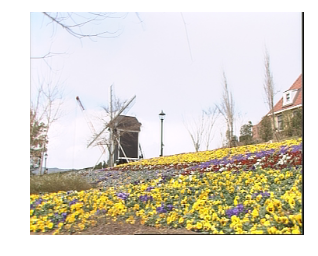

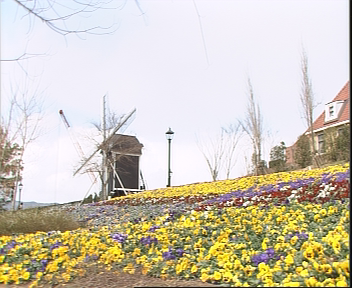

(AllIntra) Label is 0 Average predicted quant is 20.5404040404 and mode is 7


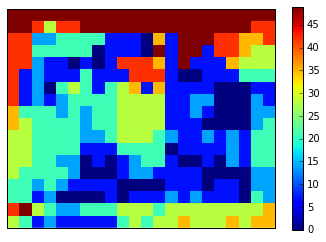

(AllVid) Label is 0 Average predicted quant is 25.4191919192 and mode is 21


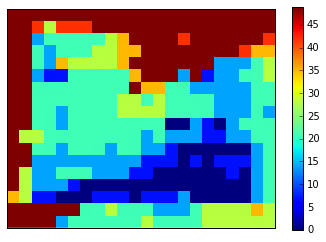

(UCID) Label is 0 Average predicted quant is 16.7222222222 and mode is 0


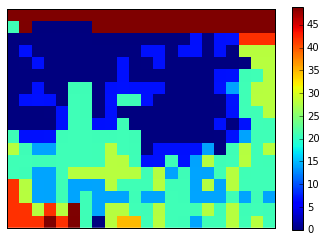

Quant is 7
Shape of the data: (152064,)


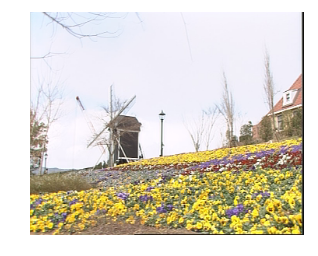

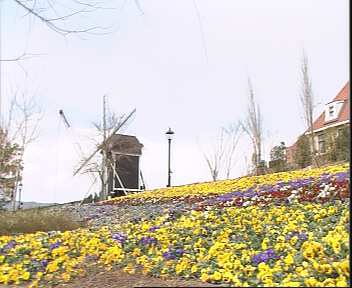

(AllIntra) Label is 7 Average predicted quant is 23.7575757576 and mode is 21


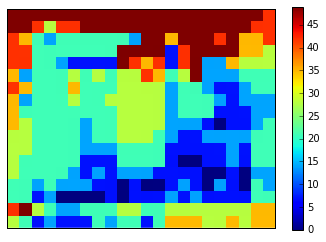

(AllVid) Label is 7 Average predicted quant is 25.7196969697 and mode is 21


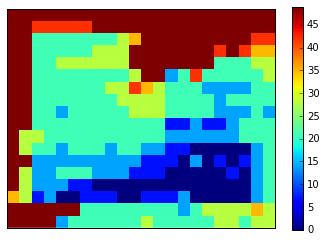

(UCID) Label is 7 Average predicted quant is 21.0176767677 and mode is 21


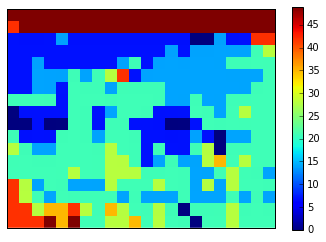

Quant is 14
Shape of the data: (152064,)


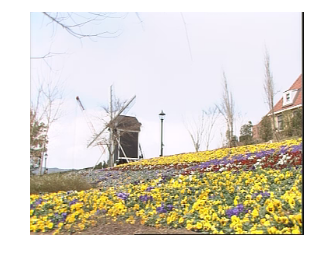

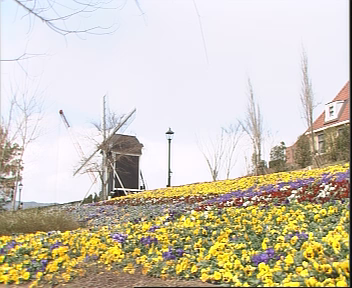

(AllIntra) Label is 14 Average predicted quant is 25.8080808081 and mode is 21


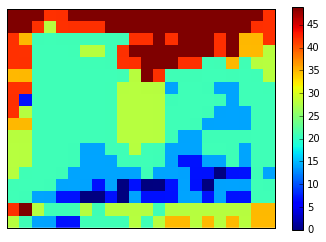

(AllVid) Label is 14 Average predicted quant is 26.1616161616 and mode is 21


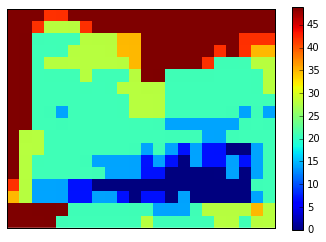

(UCID) Label is 14 Average predicted quant is 23.1919191919 and mode is 21


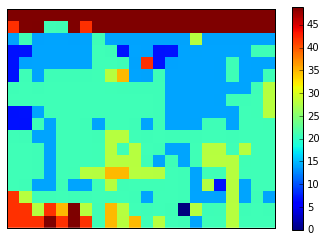

Quant is 21
Shape of the data: (152064,)


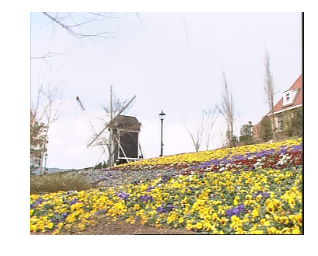

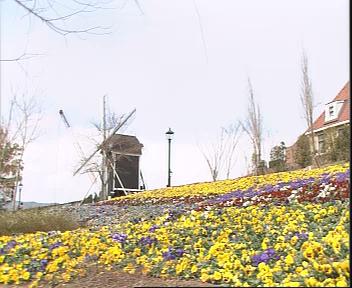

(AllIntra) Label is 21 Average predicted quant is 27.5934343434 and mode is 21


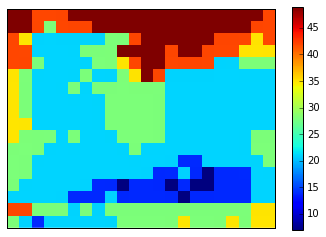

(AllVid) Label is 21 Average predicted quant is 27.6818181818 and mode is 21


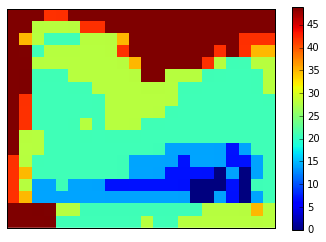

(UCID) Label is 21 Average predicted quant is 26.4974747475 and mode is 21


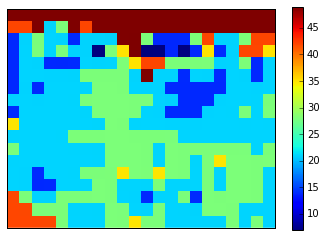

Quant is 28
Shape of the data: (152064,)


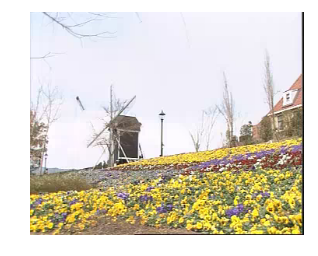

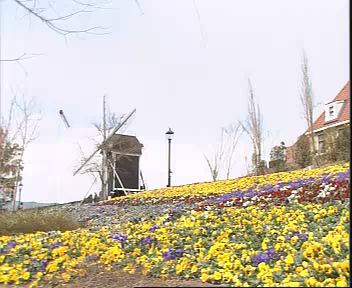

(AllIntra) Label is 28 Average predicted quant is 30.3333333333 and mode is 28


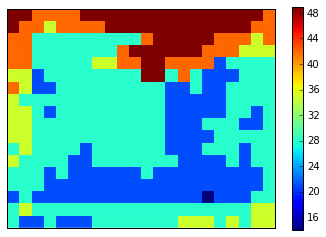

(AllVid) Label is 28 Average predicted quant is 30.4393939394 and mode is 28


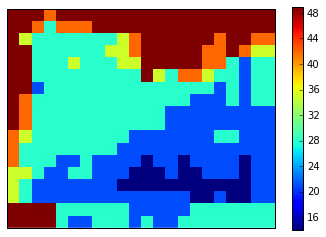

(UCID) Label is 28 Average predicted quant is 30.3333333333 and mode is 28


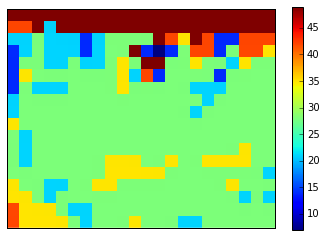

Quant is 35
Shape of the data: (152064,)


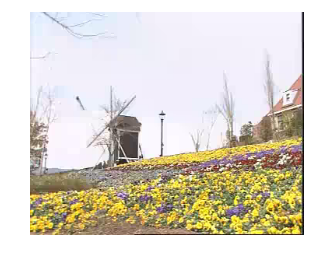

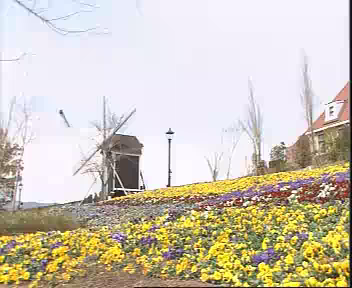

(AllIntra) Label is 35 Average predicted quant is 33.3560606061 and mode is 28


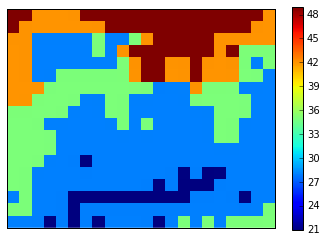

(AllVid) Label is 35 Average predicted quant is 33.0378787879 and mode is 28


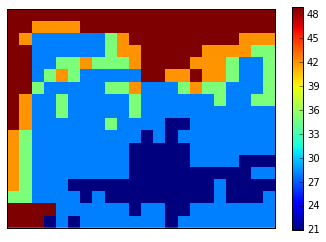

(UCID) Label is 35 Average predicted quant is 35.6363636364 and mode is 35


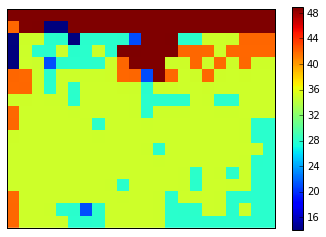

Quant is 42
Shape of the data: (152064,)


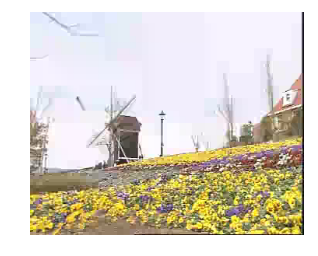

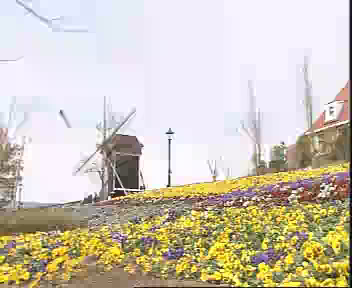

(AllIntra) Label is 42 Average predicted quant is 39.101010101 and mode is 35


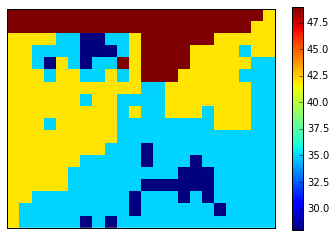

(AllVid) Label is 42 Average predicted quant is 37.9166666667 and mode is 35


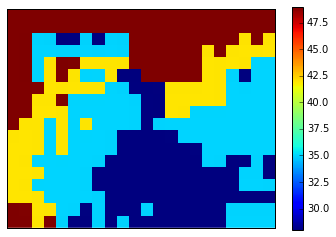

(UCID) Label is 42 Average predicted quant is 42.0883838384 and mode is 42


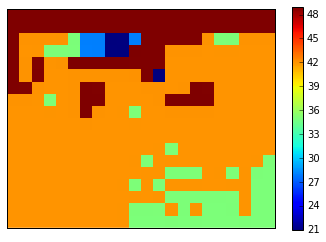

Quant is 49
Shape of the data: (152064,)


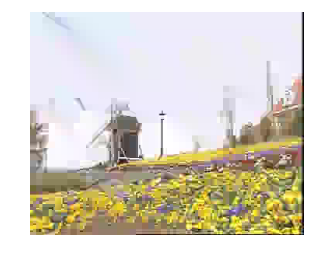

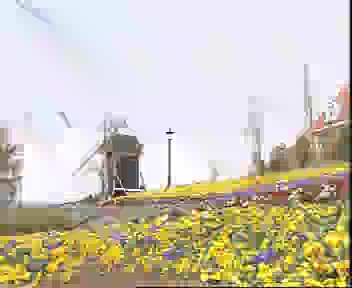

(AllIntra) Label is 49 Average predicted quant is 42.4242424242 and mode is 42


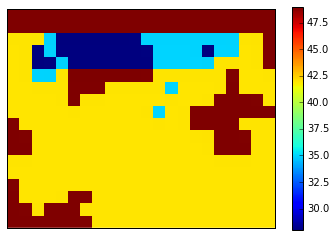

(AllVid) Label is 49 Average predicted quant is 45.0580808081 and mode is 49


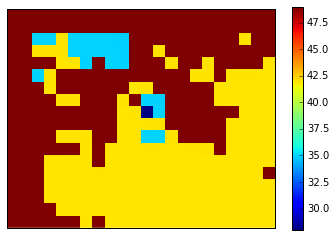

(UCID) Label is 49 Average predicted quant is 45.4646464646 and mode is 49


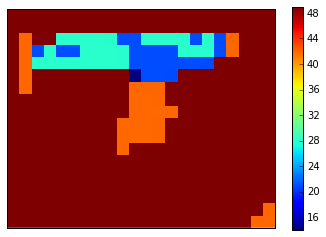

In [14]:
def YUV420_2_YUV444(data, width, height):
    #print("YUV420_2_YUV444")
    picture = np.array(data)
    picSize = int(width*height)
    colourWidth = int(width/2)
    colourHeight = int(height/2)

    colourSize = int(picSize*5/4)
    #picture = pic_planar.reshape(3, width, height)
    y = np.array(picture[0:picSize])
    
    u = np.array(picture[picSize:colourSize])
    u = u.reshape(colourWidth, colourHeight)
    #print("The old shape of u: "+ str(u.shape))
    #print(u)
    u = np.repeat(u, 2, axis=0)
    #print("The new shape of u: "+ str(u.shape))
    #print(u)
    u = np.repeat(u, 2, axis=1)
    #print("The new shape of u: "+ str(u.shape))
    #print(u)
    
    v = np.array(picture[colourSize:])
    v = v.reshape(colourWidth, colourHeight)
    #print("The old shape of v: "+ str(v.shape))
    #print(v)
    v = np.repeat(v, 2, axis=0)
    #print("The new shape of v: "+ str(v.shape))
    #print(u)
    v = np.repeat(v, 2, axis=1)
    #print("The new shape of v: "+ str(v.shape))
    #print(v)
    
    
    y = y.flatten()
    u = u.flatten()
    v = v.flatten()
    
    #shape = u.shape
    #print("The new shape of u: "+ str(shape))
    yuv = np.concatenate([y,u,v])
    return yuv

def turnArrayIntoYUV(data, cellW, cellH):
    #print("Here")
    
    maximum = data.max()
    #print("The maximum is: {}".format(maximum))
    step = int(255/maximum)
    
    yuv444 = 255 - (step*data)
    yuv444 = np.repeat(yuv444, cellH, 0)
    yuv444 = np.repeat(yuv444, cellW, 1)
    uv = np.full(yuv444.shape, 128)
    yuv444 = np.append(yuv444, uv)
    yuv444 = np.append(yuv444, uv)
    #print("The new shape of yuv444: "+ str(yuv444.shape))
    return yuv444

def generateHeatmapPicture(conf_arr, pictureName, xlabels="", ylabels=""):
    #norm_conf = []
    #for i in conf_arr:
    #    a = 0
    #    tmp_arr = []
    #    a = sum(i, 0)
    #    for j in i:
    #        tmp_arr.append(float(j)/float(a))
    #    norm_conf.append(tmp_arr)

    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    #ax.set_aspect(1)
    cm_arr = [0,7,14,21,28,35,42,49]
    #print("The shape of conf_arr: {}".format(conf_arr.shape))
    res = ax.imshow(np.array(conf_arr), cmap=plt.cm.jet, interpolation='none')

    height, width = conf_arr.shape
    #print("The width is {} and height is {}".format(width, height))

    #Putting the numbers in the middle of the squares
    #for x in xrange(width):
    #    for y in xrange(height):
    #        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
    #                    horizontalalignment='center',
    #                    verticalalignment='center')

    cb = fig.colorbar(res)
    #alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    #if xlabels == "":
    #    xlabels = alphabet[:width]
    #if ylabels == "":
    #    ylabels = alphabet[:height]
        
    #plt.xticks(range(width), xlabels)
    #plt.yticks(range(height), ylabels)
    plt.tick_params(
    axis='both',       # changes apply to both axes
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelbottom='off',
    labelleft='off') # labels along the bottom edge are off
    
    plt.savefig(pictureName, format='png', bbox_inches='tight')
    plt.show()
    
def savePic(rgbframe, width, height, filename):
    test = np.asarray(rgbframe, 'u1')
    pictureA = test.reshape(3, width, height)
    pictureA = np.swapaxes(pictureA,0,1)
    pictureA = np.swapaxes(pictureA,1,2)
    pictureA = np.ndarray.flatten(pictureA)

    imageA = Image.frombytes('RGB', (width, height), pictureA)
    display(imageA)
    imageA.save(filename, "PNG")
    
def cropRGBframe(rgbframe, width, height, top, bottom, left, right):
    newframe = []
    
    print("Dimensions {} by {}".format(width, height))
    rgbframe = rgbframe.reshape((3, width, height))
    for cidx, c in enumerate(rgbframe):
        for xidx, x in enumerate(c):
            if xidx < left or xidx > (width - right):
                #print("skipping pixel {}".format(xidx))
                continue
            else:
                for yidx, y in enumerate(x):
                    if yidx < top or yidx > (height - bottom):
                        #print("skipping line {}".format(yidx))
                        continue

                        #print("xidx = {}".format(xidx))
                    else:
                        newframe = np.append(newframe, y)
    return np.asarray(newframe)

   

batchPredLabelsAll_q0  = batchPredLabelsAll_q0_AllIntra_80_100k
batchPredLabelsAll_q7  = batchPredLabelsAll_q7_AllIntra_80_100k
batchPredLabelsAll_q14 = batchPredLabelsAll_q14_AllIntra_80_100k
batchPredLabelsAll_q21 = batchPredLabelsAll_q21_AllIntra_80_100k
batchPredLabelsAll_q28 = batchPredLabelsAll_q28_AllIntra_80_100k
batchPredLabelsAll_q35 = batchPredLabelsAll_q35_AllIntra_80_100k
batchPredLabelsAll_q42 = batchPredLabelsAll_q42_AllIntra_80_100k       
batchPredLabelsAll_q49 = batchPredLabelsAll_q49_AllIntra_80_100k       


width = 352
height = 288
channels = 3

batchPredLabelsAlls = [batchPredLabelsAll_q0, batchPredLabelsAll_q7, batchPredLabelsAll_q14, batchPredLabelsAll_q21, batchPredLabelsAll_q28, 
                       batchPredLabelsAll_q35, batchPredLabelsAll_q42, batchPredLabelsAll_q49]
pictures = ["/Users/pam/Documents/data/yuv/flower_1f_q0.yuv", "/Users/pam/Documents/data/yuv/flower_1f_q7.yuv", "/Users/pam/Documents/data/yuv/flower_1f_q14.yuv",
           "/Users/pam/Documents/data/yuv/flower_1f_q21.yuv", "/Users/pam/Documents/data/yuv/flower_1f_q28.yuv", "/Users/pam/Documents/data/yuv/flower_1f_q35.yuv",
           "/Users/pam/Documents/data/yuv/flower_1f_q42.yuv", "/Users/pam/Documents/data/yuv/flower_1f_q49.yuv"]
batchPredLabelsAlls_AllIntra_80_400k = [batchPredLabelsAll_q0_AllIntra_80_400k, batchPredLabelsAll_q7_AllIntra_80_400k, 
                                        batchPredLabelsAll_q14_AllIntra_80_400k, batchPredLabelsAll_q21_AllIntra_80_400k, 
                                        batchPredLabelsAll_q28_AllIntra_80_400k, batchPredLabelsAll_q35_AllIntra_80_400k, 
                                        batchPredLabelsAll_q42_AllIntra_80_400k, batchPredLabelsAll_q49_AllIntra_80_400k]

batchPredLabelsAlls_AllVid_80_400k = [batchPredLabelsAll_q0_AllVid_80_400k, batchPredLabelsAll_q7_AllVid_80_400k, 
                                        batchPredLabelsAll_q14_AllVid_80_400k, batchPredLabelsAll_q21_AllVid_80_400k, 
                                        batchPredLabelsAll_q28_AllVid_80_400k, batchPredLabelsAll_q35_AllVid_80_400k, 
                                        batchPredLabelsAll_q42_AllVid_80_400k, batchPredLabelsAll_q49_AllVid_80_400k]

batchPredLabelsAlls_UCID_80_400k = [batchPredLabelsAll_q0_UCID_80_400k, batchPredLabelsAll_q7_UCID_80_400k, 
                                        batchPredLabelsAll_q14_UCID_80_400k, batchPredLabelsAll_q21_UCID_80_400k, 
                                        batchPredLabelsAll_q28_UCID_80_400k, batchPredLabelsAll_q35_UCID_80_400k, 
                                        batchPredLabelsAll_q42_UCID_80_400k, batchPredLabelsAll_q49_UCID_80_400k]


image = '/Users/pam/Documents/data/yuv/flower_1f_q0.yuv'
blockW = 16
blockH = 16
imageBlockWidth = int(width/blockW)
imageBlockHeight = int(height/blockH)
totalBlocks = imageBlockWidth * imageBlockHeight



for idx, image in enumerate(pictures):
    print("Quant is {}".format(idx*7))
    f = open(image, "rb")
    allTheData = np.fromfile(f, 'u1')
    print("Shape of the data: {}".format(allTheData.shape))
    frame = YUV420_2_YUV444(allTheData, height, width)
    rgbframe = planarYUV_2_planarRGB(frame, height, width)
    
    #rgbframe2 = cropRGBframe(rgbframe, width, height, 32, 32, 32, 32)
    
    display_image_rgb(rgbframe, height, width)
    #display_image_rgb(rgbframe2, height-64, width-64)

    savePic(rgbframe, width, height, "fig_flowers_q{}".format(idx*7))


    batchPredLabelsAll = batchPredLabelsAlls_AllIntra_80_400k[idx]

    batchPredLabels = np.asarray(batchPredLabelsAll[0:totalBlocks])
    averageQP = np.average(batchPredLabels)
    counts = np.bincount(batchPredLabels)
    modeQP = np.argmax(counts)
    print("(AllIntra) Label is {} Average predicted quant is {} and mode is {}".format((idx*7), (averageQP*7), (modeQP*7)))
    batchPredLabels = batchPredLabels.reshape(imageBlockHeight, imageBlockWidth)
    #print(batchPredLabels)
    yuvFrame = turnArrayIntoYUV(batchPredLabels, 16, 16)
    frame = yuvFrame
    rgbframe = planarYUV_2_planarRGB(frame, height, width)
    #display_image_rgb(rgbframe, height, width)
    
    generateHeatmapPicture(7*batchPredLabels, "fig_heatmap_nwa10_AllIntra_80_400k_q{}.png".format(idx*7))



    batchPredLabelsAll = batchPredLabelsAlls_AllVid_80_400k[idx]

    batchPredLabels = np.asarray(batchPredLabelsAll[0:totalBlocks])
    averageQP = np.average(batchPredLabels)
    counts = np.bincount(batchPredLabels)
    modeQP = np.argmax(counts)
    print("(AllVid) Label is {} Average predicted quant is {} and mode is {}".format((idx*7), (averageQP*7), (modeQP*7)))
    batchPredLabels = batchPredLabels.reshape(imageBlockHeight, imageBlockWidth)
    #print(batchPredLabels)
    yuvFrame = turnArrayIntoYUV(batchPredLabels, 16, 16)
    frame = yuvFrame
    rgbframe = planarYUV_2_planarRGB(frame, height, width)
    #display_image_rgb(rgbframe, height, width)
    
    generateHeatmapPicture(7*batchPredLabels, "fig_heatmap_nwa10_AllVid_80_400k_q{}.png".format(idx*7))

    
    batchPredLabelsAll = batchPredLabelsAlls_UCID_80_400k[idx]

    batchPredLabels = np.asarray(batchPredLabelsAll[0:totalBlocks])
    averageQP = np.average(batchPredLabels)
    counts = np.bincount(batchPredLabels)
    modeQP = np.argmax(counts)
    print("(UCID) Label is {} Average predicted quant is {} and mode is {}".format((idx*7), (averageQP*7), (modeQP*7)))
    batchPredLabels = batchPredLabels.reshape(imageBlockHeight, imageBlockWidth)
    #print(batchPredLabels)
    yuvFrame = turnArrayIntoYUV(batchPredLabels, 16, 16)
    frame = yuvFrame
    rgbframe = planarYUV_2_planarRGB(frame, height, width)
    #display_image_rgb(rgbframe, height, width)
    
    generateHeatmapPicture(7*batchPredLabels, "fig_heatmap_nwa10_UCID_80_400k_q{}.png".format(idx*7))








In [24]:
fake_frame_hm = [7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 4, 5, 5, 4, 3, 3, 0, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 6, 6, 7, 7, 7, 7, 4, 4, 7, 7, 7, 7, 7, 7, 7, 6, 5, 4,
       4, 3, 3, 3, 1, 3, 3, 4, 3, 2, 1, 7, 7, 7, 6, 5, 4, 4, 4, 3, 5, 3, 4,
       3, 3, 3, 3, 0, 3, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 5, 3, 4, 4, 4, 4, 3,
       3, 3, 3, 7, 7, 7, 3, 3, 4, 4, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 1, 0, 3,
       3, 3, 1, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 0, 4, 4, 4, 4, 3, 3, 4,
       4, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 7, 6, 5, 5, 4, 4, 4,
       0, 3, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 0, 4, 3, 1, 3, 1, 2, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 1, 4, 4, 5, 5, 4, 4, 5, 5, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 3, 4, 5, 5, 5, 5, 4, 4, 4, 0, 3, 3, 4, 3, 3, 2, 2, 1, 1, 1, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 5,
       0, 0, 3, 2, 2, 3, 2, 1, 3, 1, 1, 2, 2, 2, 1, 4, 4, 5, 5, 5, 4, 5, 5,
       3, 5, 5, 5, 6, 6, 6, 6, 6, 6, 5, 5, 6, 3, 4, 5, 5, 5, 5, 4, 4, 2, 0,
       3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 1, 1, 0, 3, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1,
       2, 2, 3, 4, 4, 4, 2, 5, 5, 6, 5, 5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 6, 6,
       7, 6, 4, 3, 4, 4, 4, 4, 3, 0, 0, 1, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3,
       3, 3, 1, 1, 2, 2, 2, 3, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 0,
       0, 3, 2, 2, 2, 2, 2, 1, 0, 0, 0, 1, 0, 4, 4, 4, 4, 2, 5, 6, 6, 5, 5,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 5, 6, 6, 7, 3, 0, 0, 4, 4, 4, 4, 4, 3, 3,
       3, 3, 3, 1, 0, 0, 0, 0, 3, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 1, 0, 3, 2, 2, 1, 1, 0, 0, 0, 0, 4,
       0, 4, 4, 5, 5, 6, 6, 6, 6, 4, 5, 4, 4, 5, 6, 6, 6, 6, 6, 6, 5, 6, 7,
       7, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 3, 1, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 3, 3, 4, 3, 3, 3, 2, 2, 3, 1, 3, 3, 3,
       3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 4, 4, 5, 4, 6, 6, 6, 7, 4, 5, 4,
       5, 6, 6, 6, 7, 6, 6, 6, 5, 6, 7, 7, 3, 0, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       2, 1, 3, 0, 0, 0, 0, 3, 3, 2, 3, 2, 2, 3, 4, 4, 4, 4, 0, 2, 3, 3, 3,
       3, 3, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2,
       3, 4, 4, 4, 4, 4, 6, 7, 5, 5, 5, 5, 7, 6, 7, 7, 6, 6, 6, 4, 6, 7, 7,
       7, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 1, 1, 0, 3, 3, 1, 3, 3, 3, 3, 3,
       4, 6, 5, 5, 5, 4, 0, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3,
       3, 2, 1, 1, 1, 0, 0, 0, 1, 3, 3, 4, 4, 4, 4, 4, 5, 6, 7, 6, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3,
       3, 3, 0, 1, 0, 0, 1, 3, 3, 3, 3, 4, 6, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3,
       3, 3, 3, 3, 3, 1, 2, 5, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 1, 3, 3, 3, 4,
       5, 5, 4, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 6, 4,
       2, 3, 3, 4, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 1, 3, 4, 4, 3,
       6, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 1, 1, 1, 0, 0, 0, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 2, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 4, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 1, 1, 1, 0, 0, 1, 6, 5, 5, 5, 4, 5, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 4, 3,
       3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 1, 3, 4, 0, 5, 0, 6,
       6, 6, 6, 5, 5, 4, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4, 5, 4, 4, 4, 3, 3,
       4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 6, 4, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 5, 4, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 3, 3, 1, 3, 3, 4, 4, 4, 6, 6, 6, 5, 4, 4, 3, 3, 4, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 5, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       4, 4, 4, 3, 3, 6, 6, 6, 6, 6, 5, 7, 7, 7, 7, 7, 7, 6, 7, 6, 3, 4, 4,
       3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 0, 3, 3, 0, 0, 0, 5, 6,
       5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 2, 3, 3, 2, 1, 3, 4, 4, 4, 4, 6, 5, 6, 7, 6, 6, 7, 7, 7,
       7, 7, 7, 6, 7, 7, 7, 7, 3, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 0, 3, 0, 0, 0, 0, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 1, 3, 4, 4,
       3, 4, 6, 6, 7, 7, 6, 6, 7, 7, 7, 6, 6, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 3, 1, 0, 4, 3, 0, 0, 0, 5, 5, 4,
       4, 3, 3, 3, 3, 3, 3, 3, 2, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 4, 4,
       4, 5, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 6, 7, 5, 6, 6, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 3, 1, 3, 3, 3, 4, 0, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       3, 3, 4, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5,
       4, 3, 4, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 0, 3, 2, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 4, 4, 1, 3, 1, 1, 1, 3, 4, 4, 3, 4,
       4, 4, 4, 4, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 2, 0, 0, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 4, 7, 5, 5, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 3, 4, 4, 4, 6, 4, 5, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       4, 3, 3, 3, 1, 1, 3, 4, 4, 3, 4, 0, 4, 4, 4, 5, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 3, 0, 0, 6, 6, 6, 7, 7, 7, 7, 7, 5, 5, 7, 6, 5, 7, 5, 5, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 5, 4, 4, 5, 4, 3,
       4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 6, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 6, 7, 7, 5, 5, 4, 4, 4, 5, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4,
       3, 3, 4, 4, 4, 5, 4, 5, 5, 5, 4, 5, 5, 4, 4, 3, 3, 3, 1, 1, 3, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 4, 4, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 5, 7, 5, 4, 4, 4, 3,
       3, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 5, 5, 5, 5, 4, 5,
       5, 4, 4, 3, 3, 3, 0, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 3, 2, 2, 3, 4, 4, 4, 4, 3, 3, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 5, 5, 7, 4, 4, 4, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 3, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 5, 4, 1, 3, 3, 0, 0, 0, 0, 3, 4,
       4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 3,
       3, 4, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 7, 7, 4, 4, 4, 3, 5,
       3, 4, 4, 4, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 3, 3, 4, 4, 5, 5, 4, 4, 5,
       3, 3, 0, 0, 0, 0, 0, 3, 1, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 3, 3, 3, 4, 4, 4, 5, 5, 4, 3, 3, 2, 2, 0, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 5, 4, 7, 5, 5, 4, 4, 4, 5, 4, 3, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 3, 3, 4, 5, 5, 5, 5, 4, 4, 3, 0, 0, 0, 0, 0, 0, 3, 1, 1, 3, 3, 4,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 2, 2, 2, 3, 3, 4, 5, 4, 3, 2,
       1, 1, 1, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 7, 4, 5, 4, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 6, 6, 5, 4, 4, 3, 0,
       0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 4, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3,
       3, 1, 2, 2, 3, 3, 3, 4, 2, 2, 2, 1, 2, 3, 2, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 5, 5, 7, 5, 5, 4, 4, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3,
       4, 4, 4, 5, 6, 5, 4, 3, 3, 1, 0, 0, 0, 0, 0, 3, 3, 1, 2, 3, 2, 3, 2,
       1, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 4, 1, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2,
       3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 7, 6, 7, 4, 4, 4, 4, 3, 3,
       3, 3, 2, 2, 2, 2, 4, 5, 4, 4, 4, 4, 4, 5, 6, 5, 5, 4, 4, 1, 3, 0, 0,
       0, 0, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0,
       1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       5, 5, 7, 4, 7, 4, 4, 4, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4,
       5, 6, 5, 5, 4, 3, 3, 0, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 4, 7, 7, 7, 7, 7, 7, 7, 7, 5, 4, 4, 7, 6, 7, 5, 4, 4, 4, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 4, 4, 4, 3, 3, 3, 0, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4,
       4, 6, 6, 6, 5, 4, 4, 4, 4, 3, 3, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       5, 4, 4, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 3, 7, 2, 5, 4, 4, 4, 4, 4, 3, 2, 3,
       2, 3, 3, 3, 4, 3, 4, 4, 5, 5, 5, 4, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1,
       3, 3, 3, 3, 2, 2, 4, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0,
       0, 1, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3,
       6, 4, 5, 4, 3, 3, 4, 3, 3, 2, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 4,
       3, 4, 4, 4, 3, 3, 2, 2, 1, 1, 1, 3, 2, 1, 3, 3, 3, 0, 1, 1, 3, 3, 1,
       1, 0, 0, 1, 0, 3, 0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 4, 3, 3, 5, 5, 5, 4, 3, 3, 4, 3, 3, 2, 1, 2,
       1, 1, 3, 3, 4, 4, 4, 4, 5, 5, 6, 6, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 0, 4, 3, 3, 3, 1, 0, 0, 0, 1, 1, 3, 3, 1, 1, 0, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 5,
       5, 5, 5, 4, 4, 4, 3, 3, 2, 2, 3, 3, 0, 3, 4, 4, 4, 4, 4, 4, 3, 2, 2,
       2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 0, 0,
       0, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 4, 3, 7, 7,
       7, 7, 7, 7, 7, 7, 4, 2, 2, 4, 4, 5, 4, 5, 4, 3, 3, 3, 3, 3, 2, 2, 3,
       1, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 2, 3, 1, 2, 3, 2, 4, 4, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 3, 2, 2, 1, 1, 0, 1, 1, 4, 3, 4, 3, 3, 3, 3, 3, 3,
       3, 4, 3, 3, 4, 0, 0, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 2, 3, 4, 4,
       7, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 3,
       4, 3, 1, 0, 0, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 2, 3, 3, 3, 3, 3, 4, 3,
       4, 4, 4, 3, 3, 3, 3, 3, 1, 2, 2, 3, 3, 3, 3, 4, 1, 0, 4, 7, 7, 7, 7,
       7, 7, 7, 7, 6, 7, 7, 2, 3, 3, 4, 5, 5, 4, 4, 4, 3, 3, 4, 2, 2, 1, 3,
       3, 4, 4, 4, 3, 3, 3, 2, 2, 2, 3, 3, 3, 1, 0, 0, 3, 4, 3, 4, 3, 3, 3,
       3, 2, 0, 3, 3, 3, 2, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3, 1, 3, 1, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 2, 3, 4, 4, 4,
       4, 4, 4, 4, 3, 2, 4, 7, 7, 3, 3, 3, 3, 4, 4, 3, 3, 3, 2, 2, 2, 3, 4,
       4, 4, 4, 4, 3, 4, 4, 4, 5, 4, 3, 4, 3, 3, 3, 3, 0, 0, 1, 1, 3, 4, 4,
       4, 3, 3, 3, 1, 1, 4, 0, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 7, 7, 7, 7, 7,
       7, 7, 7, 6, 7, 7, 2, 3, 4, 4, 4, 3, 3, 4, 3, 3, 2, 7, 7, 7, 4, 4, 4,
       3, 6, 3, 3, 3, 2, 3, 4, 3, 4, 5, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4,
       3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 4, 3, 3, 3, 0, 0, 1, 3, 1, 3, 3, 3, 3,
       3, 3, 2, 1, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 2, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 7, 5, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 3, 2, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 0, 0, 0, 4, 4, 5, 5, 5,
       5, 5, 4, 4, 3, 4, 3, 4, 3, 4, 3, 5, 5, 5, 3, 0, 0, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 5, 6, 6, 7, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 5, 5, 1, 3, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       4, 6, 5, 0, 0, 4, 4, 3, 5, 5, 4, 5, 6, 5, 5, 5, 3, 6, 4, 5, 5, 4, 5,
       6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6,
       6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 3, 4, 5, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7]

creepy2_f1 = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1,
       5, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 2, 2,
       3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 5, 5, 5, 6, 5, 4, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 5,
       5, 5, 6, 6, 6, 7, 6, 6, 1, 3, 6, 5, 4, 4, 4, 3, 4, 3, 3, 4, 3, 3, 3,
       3, 4, 4, 3, 3, 3, 3, 2, 2, 2, 3, 3, 4, 5, 5, 4, 4, 3, 3, 3, 3, 4, 4,
       4, 4, 3, 3, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 5, 5, 5, 4, 4,
       4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 4, 4, 2, 2, 7, 6,
       4, 4, 3, 3, 4, 3, 3, 4, 3, 2, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3,
       4, 4, 5, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 5, 5, 5, 5, 5, 4, 4,
       4, 4, 5, 6, 6, 5, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3,
       4, 4, 4, 4, 4, 4, 4, 3, 3, 7, 6, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 4, 3, 3, 4, 3, 3, 3, 4, 4, 4, 3, 3, 4, 3, 4, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 4, 4, 5, 6, 6, 7, 7, 5, 4, 4, 4, 3, 4,
       3, 3, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 7, 6, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 5, 5, 5, 5, 5, 4, 4,
       4, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 5, 5,
       5, 4, 4, 4, 4, 4, 3, 3, 7, 6, 3, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 3, 4, 5, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5, 5, 5, 4, 5, 4, 3, 2, 3,
       2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 3, 3, 7, 6, 3, 3,
       3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4,
       3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 5, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 5, 4, 3, 2, 2, 2, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 4, 4, 3, 3, 7, 6, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3,
       4, 3, 5, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 3, 7, 6, 3, 4, 4,
       4, 3, 4, 3, 3, 4, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 4, 4, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 4, 2, 4, 3, 4, 3, 3, 3, 3, 4, 4, 4,
       3, 3, 4, 4, 4, 4, 2, 2, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 3, 3, 4, 3, 3,
       3, 4, 4, 3, 3, 4, 7, 6, 3, 3, 3, 3, 2, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 4,
       3, 4, 3, 3, 3, 3, 3, 4, 5, 4, 4, 3, 4, 4, 4, 4, 4, 2, 3, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 4, 3, 3, 4, 7, 6, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 3, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 4, 4,
       4, 4, 4, 3, 4, 3, 3, 5, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 3, 3, 4, 7, 6, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 4, 4, 4,
       3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 5, 4, 5, 4, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 7, 6, 3, 3, 3, 4, 3,
       4, 3, 3, 3, 4, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3,
       4, 4, 3, 5, 7, 6, 3, 3, 3, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 3, 3, 3, 4, 4, 4, 3, 5, 3, 4, 4, 4, 4, 5, 3, 3, 4, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 5, 5, 5, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 5, 7, 5, 3, 4, 3, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 3, 3, 3,
       4, 3, 3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 4, 4, 4,
       4, 4, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4,
       3, 3, 4, 1, 2, 4, 4, 3, 4, 4, 3, 3, 4, 3, 4, 4, 4, 3, 3, 3, 3, 5, 4,
       4, 4, 4, 3, 4, 3, 4, 5, 3, 3, 4, 4, 4, 5, 4, 4, 4, 4, 3, 3, 3, 3, 4,
       3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 5, 4, 4, 3, 4, 4, 3, 3, 4, 3, 3, 3, 2,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 0, 5, 4, 4, 3, 4, 4, 3, 3,
       4, 4, 4, 4, 4, 4, 3, 3, 3, 5, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4,
       5, 5, 4, 4, 4, 4, 3, 4, 5, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4,
       4, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 4, 4, 3, 3, 4, 3, 4, 4, 4, 4,
       3, 5, 1, 2, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 4, 3, 2, 2, 3, 3, 3, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 3, 2, 2, 2,
       3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 5, 2, 2, 4, 4, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 2, 3, 3, 4, 4, 4, 5,
       5, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 4, 4, 3, 4, 4, 4, 4, 5, 4, 5, 3,
       5, 2, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4,
       3, 4, 3, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 2, 2, 2,
       2, 2, 3, 3, 3, 4, 5, 4, 5, 5, 3, 6, 2, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4,
       4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 3, 4, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 3, 4, 3, 3, 3, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4,
       4, 4, 3, 4, 4, 5, 5, 6, 5, 2, 3, 2, 2, 2, 4, 4, 4, 4, 3, 3, 3, 6, 6,
       1, 6, 4, 4, 4, 4, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 3, 3, 3, 4, 4, 5, 4, 4, 4, 3, 4, 4, 4, 4, 5, 2, 2, 2,
       2, 2, 4, 4, 3, 4, 4, 3, 3, 3, 6, 1, 6, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 3, 3, 3, 3, 4, 4, 4, 5, 4,
       5, 4, 4, 4, 4, 4, 4, 4, 3, 2, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 3, 5, 5,
       5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4,
       4, 4, 3, 4, 3, 4, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5, 4, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 5, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 3, 4, 3, 4, 4, 5, 4, 4, 3, 4, 4, 4, 4, 4, 5, 4, 4, 5, 3, 3, 3, 5,
       4, 4, 4, 4, 4, 5, 4, 4, 2, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 5, 5,
       4, 4, 4, 3, 4, 4, 4, 4, 5, 5, 5, 4, 3, 4, 4, 4, 4, 4, 4, 3, 2, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 5, 4,
       4, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 5, 5, 5, 5,
       4, 4, 4, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 7, 5, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 6, 5, 4, 4, 4, 5, 5, 5, 5, 6, 5, 5, 4, 4, 4,
       4, 5, 5, 4, 4, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 2, 2, 2, 3, 4, 3, 3, 4,
       4, 3, 4, 4, 4, 3, 4, 4, 5, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 3, 4, 4, 3,
       4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 6, 5, 4, 5,
       5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       3, 3, 2, 2, 1, 2, 3, 4, 3, 3, 4, 3, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 6, 5, 6, 5, 5, 5, 4, 5, 4, 4, 4, 5, 5, 5, 5, 4, 4,
       4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 4, 4, 4, 3, 3,
       4, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 5, 6, 4, 5, 5,
       4, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3,
       3, 3, 3, 4, 3, 3, 4, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 5,
       5, 4, 4, 4, 3, 4, 3, 5, 3, 5, 5, 5, 3, 2, 3, 3, 5, 5, 4, 4, 4, 4, 5,
       5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3, 2, 5, 2, 5, 5, 2,
       4, 2, 2, 2, 6, 6, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3,
       3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 5,
       4, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4,
       4, 5, 5, 3, 3, 3, 5, 5, 4, 3, 3, 3, 2, 2, 2, 2, 6, 5, 5, 5, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 5, 4, 2, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 2, 2, 2, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 3, 4,
       4, 4, 3, 4, 4, 3, 2, 4, 3, 3, 4, 4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4,
       4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       6, 6, 2, 3, 3, 4, 4, 4, 4, 3, 3, 3, 2, 2, 3, 3, 3, 3, 4, 4, 4, 3, 3,
       3, 3, 3, 3, 4, 3, 2, 2, 2, 2, 3, 4, 3, 3, 3, 4, 3, 2, 3, 3, 4, 4, 4,
       5, 4, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 4,
       4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 6, 2, 3, 3, 5, 5, 5, 5, 5, 5, 4,
       3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 5, 4,
       4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 4, 3, 4, 3, 3, 3, 3, 3, 2, 3,
       3, 2, 3, 3, 4, 4, 4, 3, 6, 6, 5, 5, 3, 4, 4, 3, 3, 3, 2, 2, 2, 3, 3,
       3, 4, 4, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 4, 4, 4, 4, 4,
       4, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 4, 5, 4, 5, 5, 4, 4, 4, 4, 3, 4, 3, 4, 4, 5, 5, 5, 6, 6, 6,
       4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 5, 5, 5, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 5,
       4, 4, 3, 5, 4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 3, 3, 3, 3, 4, 3, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 5, 4, 4, 3, 6, 6, 5, 6, 6, 2, 6, 6, 6,
       4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 6, 7, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 5, 3, 3, 3, 3, 3, 3, 3,
       4, 5, 5, 4, 4, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4,
       4, 3, 6, 6, 6, 6, 6, 2, 2, 6, 6, 5, 3, 4, 4, 5, 7, 7, 4, 3, 4, 5, 6,
       7, 7, 3, 4, 4, 4, 4, 4, 5, 4, 4, 3, 3, 3, 4, 4, 3, 5, 3, 5, 5, 3, 5,
       3, 3, 5, 5, 4, 5, 3, 3, 3, 4, 3, 4, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 4,
       4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7]

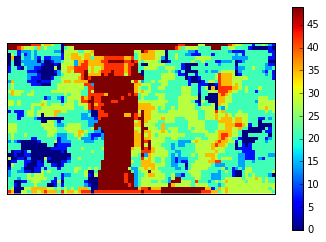

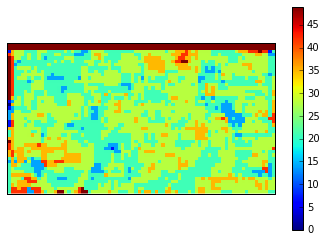

In [25]:
ff_hm = fake_frame_hm[0:3600]
ff_hm = np.asarray(ff_hm)
ff_hm = np.reshape(ff_hm, (int(720/16), int(1280/16)))
generateHeatmapPicture(7*ff_hm, "fakeFrameHeatmap.png")

ff_hm = creepy2_f1[0:3600]
ff_hm = np.asarray(ff_hm)
ff_hm = np.reshape(ff_hm, (int(720/16), int(1280/16)))
generateHeatmapPicture(7*ff_hm, "fakeFrameHeatmap.png")




Why don't we use even sized kernels?

[[1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0]
 [1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
 [1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0]
 [1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
 [1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0]
 [1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
 [1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0]
 [1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 

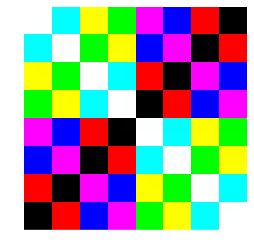

[ 1.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.  0.
  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.  0.  1.  0.
  1.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.  0.  1.  0.  1.  0.
  1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.
  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.
  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  1.  1.
  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.
  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.]
192


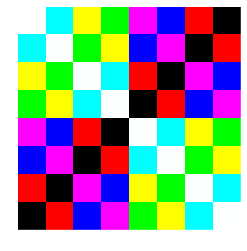

[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  1.   1.   0.   0.   1.   1.   0.   0.   0.   0.   1.   1.   0.   0.
  1.   1.   1.   0.   1.   0.   0.   1.   0.   1.   1.   0.   1.   0.   0.
  1.   0.   1. ]
48
4.0


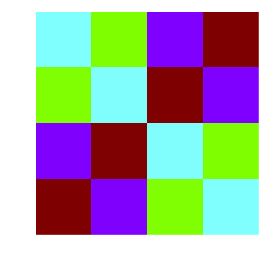

In [28]:
from scipy import signal
import math

# print("YUV444_2_YUV420_alt")
R=[[1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
   [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
   [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
   [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
   [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
   [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
   [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
   [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
   [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
   [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
   [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
   [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
   [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
   [1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0],
   [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1],
   [0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1]]

G=[[1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0],
   [1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0],
   [1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0],
   [1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0],
   [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],
   [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],
   [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],
   [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],
   [1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0],
   [1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0],
   [1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0],
   [1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0],
   [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],
   [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],
   [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1],
   [0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1]]

B=[[1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
   [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
   [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
   [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
   [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
   [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
   [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
   [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0],
   [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
   [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
   [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
   [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
   [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
   [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
   [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1],
   [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]]

a = R+B+G
height = 16
width = 16
kernel = np.array([[1, 1, 0],
                   [1, 1, 0],
                   [0, 0, 0]])
padding='same'



data=np.array(a)
print(data)
#print(np.size(data))
display_image_rgb(data, 16, 16, interp_method='none')
    
pic_planar = np.array(data)
picture = pic_planar.reshape(3, height, width)
r = picture[0]
g = picture[1]
b = picture[2]

# Perform 2D convolution with input data and kernel
r = signal.convolve2d(r, kernel, mode=padding) / kernel.sum()
r = r[::2, ::2].copy()
g = signal.convolve2d(g, kernel, mode=padding) / kernel.sum()
g = g[::2, ::2].copy()
b = signal.convolve2d(b, kernel, mode=padding) / kernel.sum()
b = b[::2, ::2].copy()

r = r.flatten()
g = g.flatten()
b = b.flatten()

# shape = u.shape
# print("The new shape of u: "+ str(shape))
rgb = np.concatenate([r, g, b])
print(rgb)
print(np.size(rgb))
h=np.size(rgb)/3
h = math.sqrt(h)
h = int(h)
display_image_rgb(rgb, h, h, interp_method='none')

width=h
height=h

pic_planar = np.array(rgb)
picture = pic_planar.reshape(3, height, width)
r = picture[0]
g = picture[1]
b = picture[2]


# Perform 2D convolution with input data and kernel
r = signal.convolve2d(r, kernel, mode=padding) / kernel.sum()
r = r[::2, ::2].copy()
g = signal.convolve2d(g, kernel, mode=padding) / kernel.sum()
g = g[::2, ::2].copy()
b = signal.convolve2d(b, kernel, mode=padding) / kernel.sum()
b = b[::2, ::2].copy()

r = r.flatten()
g = g.flatten()
b = b.flatten()

# shape = u.shape
# print("The new shape of u: "+ str(shape))
rgb = np.concatenate([r, g, b])
print(rgb)
print(np.size(rgb))
h=np.size(rgb)/3
h = math.sqrt(h)
print(h)
h = int(h)



display_image_rgb(rgb, h, h, interp_method='none')


In [ ]:
import imageio
with imageio.get_writer('/Users/pam/Documents/movie.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)